<a id="top"></a>
# Topics Outline

## [Why are 2 interacting RR robots different than a 5barlinkage?](#5bl_explanation)
## [What does the most general 5 bar linkage look like?](#g5bl_model)
 - derivation
 - gen5barlinkage class definition
 - gen5barlinkage exploration tool
 - discussion points
 
## [What does the human model look like?](#human_model)
- derivation
- human class definition
- human model exploration tool. 
- discussion points

## [Joint exploration - put the two together](#joint_exp)
- joint exploration tool 

## [Solve the constrained optimization problem](#solution)

# [notes](#notes)


<a id="5bl_explanation"></a>
# Why are 2 interacting RR robots different than a 5-bar-linkage? [ &#x21ea;](#top)



# Utility class and helper classes [ &#x21ea;](#top)

In [2]:
#check if the notebook is being used as a library, or being run as a notebook
asLibrary = lambda : '__file__' in globals()
if asLibrary():
    print("models run as library")

import numpy as np
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

class utils:
    """
    utility functions shared between different classes
    """
    @staticmethod
    def dist(x1,y1,x2,y2):
        """
        calculate the distance between 2 points
        """
        return ((x2 - x1)**2 + (y2 - y1)**2)**.5
    
    @staticmethod
    def mkCircle(x0,y0,r,n = 100):
        t = np.linspace(0,2* np.pi,n)
        x = r * np.cos(t) + x0
        y = r * np.sin(t) + y0
        return x,y

    @staticmethod
    def circIntersection(x1,y1,r1,x2,y2,r2):
        """characterize circle intersection"""
        dx = x2-x1; dy = y2-y1
        hyp = (dx**2 + dy**2)**.5
        if hyp > (r1 + r2):
            intersect = False
        else:
            intersect = True
        ipt = (x1 + (dx/2), y1 + (dy/2))
        ang = np.arctan2(dy,dx)
        return (ipt,ang,intersect)

    @staticmethod
    def withinIntersection(x1,y1,r1,x2,y2,r2,pt):
        """is the point contained within the intersection or two circles?"""
        def within(x,y,r,pt):
            dx = pt[0] - x ; dy = pt[1] - y
            hyp = (dx**2 + dy**2)**.5
            return r > hyp

        return (within(x1,y1,r1,pt) and within(x2,y2,r2,pt))
    
    @staticmethod
    def ROC(θ,upper=np.pi,lower=-np.pi):
        """
        rollover correction, to make sure the change in angle (Δθ) is accurately
        represented. the function can equally be used to find the minimal representation
        of an angle on the range (-π,π)
        """
        while (θ > upper) or (θ <  lower):
            if     θ >  upper: θ -= 2*np.pi
            elif   θ <  lower: θ += 2*np.pi
        return θ
    
    
    #notes on these angle helper functions: they all have the restriction of only working for the 
    #short way arround. if we want them to work for the long way arround, they need to be rethought
    # in the future. 
    @staticmethod
    def clampAng(ang,lower,upper):
        """
        clamp angle ang between the lower and upper angles. the implementation assumes that
        the distance between lower and upper is < π rad, and that the lower angle is "to the right"
        of the upper angle, in the context of the two angles being closer than π
        
        #note that this function doesn't operate sucessfully if lower and upper are switched, if 
         if the desired bounds between them are > np.pi
        """
        #rotate every angle so that lower is placed on the origin
        lower0 = lower 
        ang   -= lower ; upper -= lower ; lower = 0
        
        #represent all angles on (-π,π)
        ang = utils.ROC(ang) ; upper = utils.ROC(upper)
        
        #calc midline of upper and lower, and anti-midline m_bar
        midline = (upper + lower )/ 2
        m_bar = midline - np.pi
        
        #determine what angle to return, based on location
        if   ang >= lower and ang <= upper:  x = ang
        elif ang > upper:                    x = upper
        elif ang < m_bar:                    x = upper
        elif ang <= 0 and ang >= m_bar:      x = lower
        
        return x + lower0
    
    @staticmethod
    def between2Angles(a,b1,b2):
        """ is angle a between angles b1 and b2? the minimum angle"""
        #reduce angle to representation on -180 to 180
        angles= [a,b1,b2]
        angCorr = [utils.ROC(ang) for ang in angles]
        dists = [abs(utils.ROC(a-b1)),abs(utils.ROC(a-b2)),abs(utils.ROC(b1-b2))]
        if np.isclose(dists[2],dists[0] + dists[1]):
            return True
        return False
    
    
    @staticmethod
    def noNans(*args):
        """
        recursively test for the presense of a single nan
        and return false if one is encountered within the argument list
        """
        for arg in args:
            #item is iterable and therefore needs to be delt with recursively
            if hasattr(arg, '__iter__'):
                for a  in arg:
                    nn = utils.noNans(a)
                    if nn == False:
                        return False

            #item is not iterable, and can therefore be considered individually
            else:
                if np.isnan(arg):
                    return False
        #didn't encounter a nan, so we are good here.
        return True
    
    @staticmethod
    def GD(x0,df,params):
        """
        peform gradient decent, given df, a function for calculating the 
        derivate of the function to be optimized. 
        """
        next_x = x0   # We start at x0
        gamma = 0.01  # Step size multiplier
        precision = 0.0001  # Desired precision of result
        max_iters = 10000  # Maximum number of iterations
        
        for _ in range(max_iters):
            current_x = next_x
            next_x = current_x - gamma * df(current_x,params)

            step = next_x - current_x
            if abs(step) <= precision:
                break

        return next_x
    
    @staticmethod
    def Rz(θ):
        """returns matrix which rotates by theta about positive z-axis"""
        return np.array([[ np.cos(θ), -np.sin(θ)],
                         [ np.sin(θ),  np.cos(θ)]])
    
    @staticmethod
    def dictionize(obj,circ = []):
        """
        turn the state of a object into a dictionary representation of 
        that object for later reference.
        """
        #return if base object
        if not hasattr(obj,"__dict__"):
            return obj
        #make dictionary from class object
        else:
            d = {}
            for key, value in obj.__dict__.items():
                #handle circular references
                if hasattr(value,"__dict__") and value in circ:
                    pass
                elif hasattr(value,"__dict__") and value not in circ:
                    circ.append(value)
                    d[key] = utils.dictionize(value,circ)
                else:
                    d[key] = utils.dictionize(value,circ)        
            return d
        
    @staticmethod
    def detentCirc(n,θ,ϕ = 0):
        """
        take a continous circle and create n discrete detents uniformly spaced in the
        circle with phase ϕ, and snap the input angle θ to the closest detent
        inputs: 
            n - number of detents
            θ - continuous angle on [0-2π]
            ϕ - phase offset from 0 of first detent

        """
        θ = utils.ROC(θ,2*np.pi,0)            # ROC angle so its on [0-2π]
        Δ = 2*np.pi / n                       # angle between detents
        θ_detent = int((θ + (Δ/2)-ϕ)/Δ)*Δ + ϕ # snap angle to detent
        return θ_detent
    
    @staticmethod
    def test_detentCirc():
        x = np.linspace(0,2*np.pi,1000)
        y = list(map(lambda θ: utils.detentCirc(2,θ,np.pi/2), x))
        y2 = list(map(lambda θ: utils.detentCirc(2,θ,np.pi/2), x))
        fig = go.Figure(data=go.Scatter(x=x, y=y))
        fig.add_scatter(line=dict(color='gray'),x=x,y=y2)
        tickmode = "array"
        tickvals = [i * np.pi/4 for i in range(8)]
        ticktext = ["0","π/4","π/2","3π/4","π","5π/4","3π/2","7π/4"]
        fig.update_xaxes(tickmode=tickmode,tickvals=tickvals,ticktext=ticktext)
        fig.update_layout(title="circle detents, angle vs. returned value")
        fig.show()
    

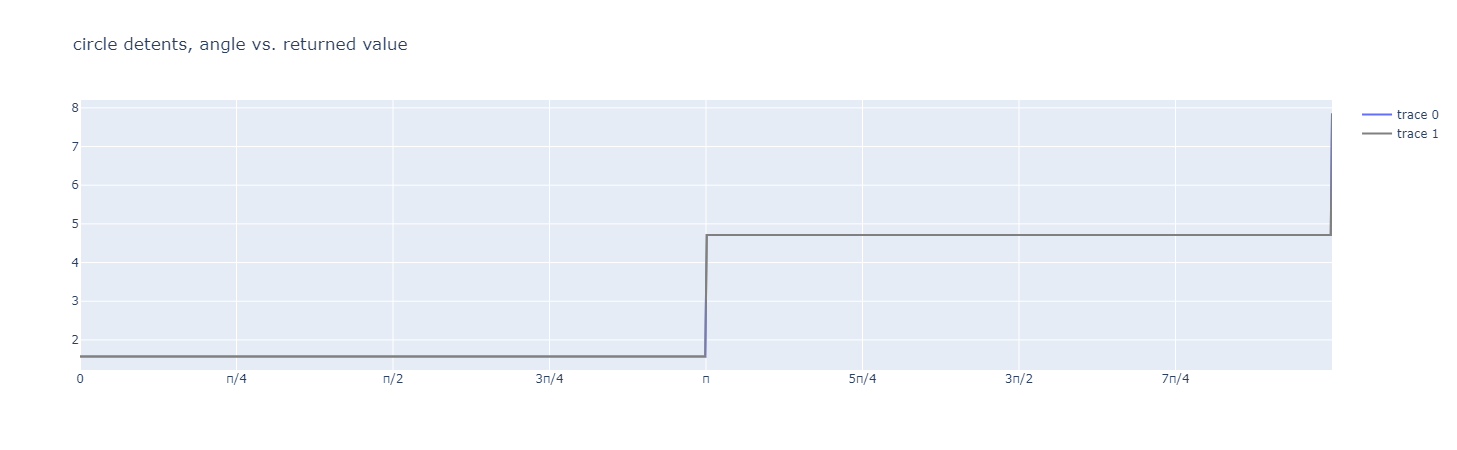

In [170]:
#utils.test_detentCirc()

# Robot base class and helper classes

<a id="g5bl_model"></a>
# What does the most general 5 bar linkage look like? [ &#x21ea;](#top)  

###  below we see a parametric representation of the kinematics of a general 5 bar linkage:

<img src="./imgs/general5bl_designParams.svg" style="width:1600px">

### * if we allow $L_{0} = 0$ and attach the end effector to $L_{2}$ with a decent sized $P_{x}$ extension segment, and place $(y_1,x_1)$ at the hip joint and $e_1$ at the knee, then we have the "exoskeleton" like design
### taken together, theses 11 variables represent the parameter space over which our optimization will ocure


The forward kinematics equations are: 

<font size="7">
$$
\begin{align*} 
X_{ee} &= L_{1l}C_{1l} + L_{2l}C_{12l} + L_{13l}C_{123l} + X_l \\ 
Y_{ee} &= L_{1l}S_{1l} + L_{2l}S_{12l} + L_{13l}S_{123l} + Y_l \\
X_{jt} &= L_{1l}S_{1l} + L_{2l}S_{12l} + X_l \\
X_{jt} &= L_{1l}S_{1l} + L_{2l}S_{12l} + Y_l \\
X_{jt} &= L_{1r}S_{1r} + L_{2r}S_{12r} + X_r \\
X_{jt} &= L_{1r}S_{1r} + L_{2r}S_{12r} + Y_r \\
\end{align*}
$$
</font>

* there are configurations for solving FK
* there are 4 configurations for solving IK
* there are 4 jacobians for the parellel robot, corresponding to each of the 4 methods. 
* i want to visualize how this effects the reciprical condition number, using our visualization techniques. 
* currently, configuration switching is not being considered in the analysis. 
    * recall that changing configurations requires passing through a singularity
* should we allow links to cross? - how would we deal with this, besides setting the value to zero when the links cross? ( assign a crossing penalty function) (0-1)
* direct penalty of singularity ()? or again should we only penalize indirectly? 
    * it seems to me that a singularity in the middle of the workspace is way worse than a singularity at then edge of the workspace. if it becomes a problem, we can invent a criteria   to elimitinate it, else carry on.

# notes on pantograph class.

* implementing pantograph was completely redundant. I did it for psychological reasons, because I was sick of looking at Gen5bl. this was a mistake.
* what I really need is a great way to dynamically re-parameterize the model, so that before I run the simulation, I can specify what the constraints are, and then the class will handle what this means in terms of setting the variables within the Gen5bl class directly. 
* this can be thought of similarly to setting the discrete states of the elbows. 

In [3]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact , Layout , FloatSlider , Checkbox , Dropdown
from IPython.display import display
from numpy import linalg as LA
from shapely.geometry import Polygon


class rTauSpace:
    """define a torque space"""
    def __init__(self,R):
        self.R = R
    def corners(self,repeat = False):
        """return the corners of the torque space polygon in CCW order from top right"""
        τ1lmax =  self.R.τ1l  #be responsive if value of τ1 changes (from reference)
        τ1lmin = -self.R.τ1l
        τ1rmax =  self.R.τ1r
        τ1rmin = -self.R.τ1r
        if repeat:
            cs = np.array([[τ1lmax,τ1lmin,τ1lmin,τ1lmax,τ1lmax],
                           [τ1rmax,τ1rmax,τ1rmin,τ1rmin,τ1rmax]])
        else:
            cs = np.array([[τ1lmax,τ1lmin,τ1lmin,τ1lmax],
                           [τ1rmax,τ1rmax,τ1rmin,τ1rmin]])
        return cs
     
#ideas for penalty functions: 
# minimize the amount that the jacobian shape changes? via minimizing the derivative of the 
# condition numbers over the set of tested points, something like that.
# penalize elbow crashing into the ground
# reward designs with sorter base of support, or shorter limb lengths. 
# penalize jacobian crossing in the middle of the workspace, this could be done explicitly in the following way: 
#     using a value function which is gaussian, create a weight where the middle of the workspace matters more than
#     edge. use the condition number to estimate the closeness to a singularity, and the product of those two value 
#     becomes a penalty.
# ****** we need to find a way to penalize when the robot can produce a ton of force, while the human cannot. this happens at high condition number, nearly always. ****
# soft - constraints when we are about to run into the boundry


# class Penalty:
#     """
#     implement penalty functions which impact the objective function value
#     """
#     def __init__(self,R):
#         self.R = R     #the robot model
#         self.penaltyFxns = ["shortSegments","f1","f2"] 
        
#     def boundary():
#         """
#         implement soft constraints (via a penalty function) on the boundary
#         """
        
#     def cost():
#         pass  #return sum of all enabled penalty functions. 
    

# class Constraints:
#     """
#     implement actual (hard) constraint functions that may be inforced by some
#     optimizers
#     """
#     def __init__(self,R):
#         self.R = R     #the robot model
#         self.constraintFxns = ["shortSegments","f1","f2"] 
    
#     def cons():
#         return []  #return function handles to each function
    
    

class Gen5barlinkage:
    """
    this General 5-bar Linkage class solves the kinematics, inverse kinematics, and 
    differential kinematics (jacobian) of a 2DOF, 5 bar linkage.
    
    design parameters: 
        states that do not change during the course of the inner-loop of the optimization
        function, and represent design decisions to be made about the robot
    """
    def __init__(self):
        #--------- continuous design parameters -----------
        
        #internal representation of robot roots
        self.xl =  0
        self.yl =  0
        self.xr = .5
        self.yr =  0
        
        #calculated polar parameterization of robot roots
        #self.L0
        #self.θ0
        
        #robot limb lengths
        self.L1l = .25      #left link 1
        self.L2l = .25      #left link 2
        self.L3l = .25      #left link 3 
        self.L1r = .25      #right link 1
        self.L2r = .25      #right link 2
        
        #angular parameter of last limb
        self.θ3l = .25      #angle parameter on [0-2π]
        
        #torque parameters
        self.τ1l = 100  #[N*m] - when τ isn't a parameter, this is the default
        self.τ1r = 100  #[N*m] - when τ isn't a parameter, this is the default
        self.τb  = 200  #[N*m] - torque budget - used when torque param active
        self.τs = rTauSpace(self)
          
        #------ discrete design parameters ---------
        
        #elbow states
        #self.e1 = 'up' # not used, due to solution method for IK  
        #self.e2 = 'up' # determined by IK
        self.ef =  'up' # the state of the ficticious elbow, a proxy for e1
        self.e3 =  'up' # state of the right robot elbow
        self.es = None  # continuous variable that encodes the discrete state of ef and e3 on [0-2π]
        
        
        #------- constraints via parameterization (cvp) -----
        
        # the roots of the right and left robot are parameterized (from the perspective of the optimizer)
        # using one cartesian (xl,yl) and one polar (L0,θ0) coordinate set, with box constraints on L0,this
        # permits a feasable annulus of possible right root locations, with (xl,yl) free to move and located
        # at the center of the annulus
        
        # parameterization modes for the locations of the roots of the right and left robot.this mode  
        # switch acts on the θ0 parameter to implement different possible right robot root locations.
        # these parameterizations are there to inforce symmetry constraints that will allow the robot to
        # be used on either the right or left side equally. 
        
        rootConstraintModes =  \
        [
            "free",        # the roots are free to be located anywhere, within the bounds of L0 box constrant
            "VH"  ,        # the roots may be located along either a vertical or horizonal axis 
            "V"   ,        # the roots may be located only along a vertical axis   
            "H"   ,        # the roots may be located only along a horizontal axis
        ]
        
        
        # parameters to include in the optimization. True allows the params to vary False excludes and sets
        # to a fixed and default level
        optionalParamList = \
        [
            "θ3l",         # θ3l differentiates the gen5bl from the pantograph
            "τ",           # motor torque for the right and left robot
            "elbowState"   # discrete elbow state, controlled by a single parameter
        ]
        
        # set the default state of the constraints via parameterization object. modify this object directly
        # before executing an experiment
        self.cvp = \
        {
            "rootMode":"free",           #string from rootConstraintModes indicating the root mode
            "optionalParams" : ["θ3l"]   #list containing all optional params present in the simulation 
        }
        
        #----- design parameter box constraints ----------
        
        #optimizer root params
        self.xl_min = -.5 ;  self.xl_max =  .5
        self.yl_min = -.5 ;  self.yl_max =  .5
        
        self.L0_min  =  0 ;  self.L0_max  =  .4  
        self.θ0_min  =  0 ;  self.θ0_max  =  2*np.pi   
        
        
        #robot limb lengths
        self.L1l_min = .1 ;  self.L1l_max = .4
        self.L2l_min = .1 ;  self.L2l_max = .4
        self.L3l_min = .1 ;  self.L3l_max = .4
        self.L1r_min = .1 ;  self.L1r_max = .4 
        self.L2r_min = .1 ;  self.L2r_max = .4
        
        #angular parameter of last limb
        self.θ3l_max = 2*np.pi
        self.θ3l_min = 0
        
        #torque magnitude bounds 
        self.τ1l_min = 10 ; self.τ1l_max = self.τb - self.τ1l_min
        
        #discrete - encoded vars
        self.es_min  =  0 ;  self.es_max  =  2*np.pi
       

        #---------- robot configuration -----------
        # internal state required for θ driven kinematics animation, not optimization
        self.θ1l = None ; self.θ2l = None ; self.θ1r = None ; self.θ2r = None
        self.Xee = None  ; self.Yee = None  
        
        #---------- penalty functions ----------
        # future.
        #self.penalty = Penalty(self)
        #self.constraints = Constraints(self)
        
        
    #----------------- optimizer state vector interface --------------------
    
    #getters and setters for (L0,θ0) parameterization
    @property #calculate L0 from internal state
    def L0(self):
        return utils.dist(self.xl,self.yl,self.xr,self.yr) 
    
    @property #calculate θ0 form internal state
    def θ0(self):
        return np.arctan2(self.yr-self.yl,self.xr-self.xl)
    
    #parameterization helper functions
    def update_L0_θ0(self,L0,θ0):
        """
        helper function for changing the internal state x2,y2 based on the polar 
        parameterization, (L0,θ0), and the currently set root constraint mode.
        """
        rm = self.cvp["rootMode"]
        if rm == "free":
            pass
        elif rm == "VH":
            θ0 = utils.detentCirc(4,θ0)
        elif rm == "V":
            θ0 = utils.detentCirc(2,θ0,np.pi/2)
        elif rm == "H":
            θ0 = utils.detentCirc(2,θ0,0)
        else:
            print("root mode not yet implemented, reconfigure cvp object")
        
        #set (xr,yr) with FK from adjusted polar
        self.xr = self.xl + L0*np.cos(θ0);
        self.yr = self.xl + L0*np.sin(θ0);

    def update_elbow_state(self,es):
        """
        helper function which maps the continuous value es [0-2π] to the discrete elbow states
        defined by self.e1 and self.ef
        """
        elbowStates = ["up","down"]
        self.ef = elbowStates[int(np.ceil(np.cos(es)))]
        self.e3 = elbowStates[int(np.ceil(np.sin(es)))]
    
    
    #state vector setters and getters
    def get_x(self):
        """
        get the state vector x from the internal state of the robot
        """
        #add definite members of the state t0 x
        x = \
        [
            self.xl,
            self.yl,
            
            self.L0,
            self.θ0, 
            
            self.L1l,
            self.L2l,
            self.L3l,
            
            self.L1r,
            self.L2r,
        ]
        
        #add optional state members based on cvp
        op = self.cvp["optionalParams"]
        if "θ3l" in op:
            x.append(self.θ3l)
    
        if "τ" in op:
            x.append(self.τ1l)
            
        if "elbowState" in op:
            x.append(self.es)
        
        return np.array(x)
    
       
    
    def set_x(self,x):
        """
        set the internal state of the robot with state vector x
        """
        #set definite members of the state
        self.xl  = x[0]
        self.yl  = x[1]  
        
        self.L0  = x[2]
        self.θ0  = x[3]
        
        self.L1l = x[4]
        self.L2l = x[5]
        self.L3l = x[6]
        
        self.L1r = x[7]
        self.L2r = x[8]
        
        #set optional members of the state 
        n = 9 
        op = self.cvp["optionalParams"]
        if "θ3l" in op:
            self.θ3l = x[n]
            n +=1
    
        if "τ" in op:
            self.τ1l = x[n]
            #linear tradeoff between τr and τl
            self.τ1r = self.τb - self.τlr 
            n +=1
            
        if "elbowState" in op:
            self.es = x[n]
            self.update_elbow_state(self.es)
            
        
            
    
    def getBounds(self):
        """
        returns the box constraint on x vector
        """
        #add manditory parameter bounds to b
        b = \
        [
            [self.xl_min,  self.xl_max],
            [self.yl_min,  self.yl_max],
            
            [self.L0_min,  self.L0_max],
            [self.θ0_min,  self.θ0_max], 
            
            [self.L1l_min,self.L1l_max],
            [self.L2l_min,self.L1l_max],
            [self.L3l_min,self.L3l_max],
            
            [self.L1r_min,self.L1r_max],
            [self.L2r_min,self.L2r_max],
        ]
        
        #add optional state member bounds based on cvp
        op = self.cvp["optionalParams"]
        if "θ3l" in op:
            b.append([self.θ3l_min,self.θ3l_max])
    
        if "τ" in op:
            b.append([self.τ1l_min,self.τ1l_max])
            
        if "elbowState" in op:
            b.append([self.es_min,self.es_max])
        
        return np.array(b)
        

    #-------------------------- kinematics ---------------------------
    def _IK_RR(self,x,y,l1,l2,elbow):
        """
        perform Inverse Kinematics on an RR robot, see lect5 p.9-10 
        """
        #solve for intermediate values
        r = utils.dist(0,0,x,y) - 1e-12 #solves numerical issue at θ2 == 0 
        β = np.arccos((l1**2 + l2**2 - r**2) / (2*l1*l2))
        γ = np.arccos((r**2 + l1**2 - l2**2) / (2*r*l1))
        α = np.arctan2(y,x)
        
        #handle different elbow states
        θ1 = α - γ
        θ2 = np.pi - β
        
        if elbow == "down":
            return θ1,θ2
        elif elbow == "up":
            θ1pm = θ1 + 2*γ  
            θ2pm = -θ2   
            return θ1pm,θ2pm
        
        
        
    def _IK_RRR(self,x,y):
        """
        perform Inverse Kinematics on an RRR robot (constituting the left side the 
        5bar linkage in the reference position), in terms of x,y,θ3 this is an analytical
        solution to the IK problem, that assumes θ3 is locked and uses a fictutious link (l_f)
        approach. 
        """
        #define local vars: 
        L1 = self.L1l; L2 = self.L2l; L3 = self.L3l; θ3 = self.θ3l
        
        #determine the wrist state based on θ3  (consider refactoring into a property?)
        θ3 = utils.ROC(θ3,lower = 0,upper = 2*np.pi)
        if θ3 >= 0 and θ3 < np.pi:
            wrist = "down"
        if θ3 >= np.pi and θ3 <= 2*np.pi:
            wrist = "up"
    
        #determine Lf, the length of the ficticious segment
        a = np.pi - θ3
        Lf = (L2**2 + L3**2 - 2*(L2)*(L3)*np.cos(a))**.5
        
        #determine the IK for the RR robot formed by L1 and the fictitious Lf 
        θ1, θ2f = self._IK_RR(x,y,L1,Lf,self.ef)
        
        #determine the FK to the first link 
        x1 = L1*np.cos(θ1); y1 = L1*np.sin(θ1)
        
        #determine the IK from the tip of the first link, to the end effector location
        θ2, θ3 = self._IK_RR(x - x1,y - y1,L2,L3,wrist)
        θ2 -= θ1                             #angle correction for different coordinate frames 
        
        return θ1,θ2,θ3
    
    
    
    def _FK_RR(self,θ1,θ2,l1,l2):
        """
        forward kinematics for RR robot
        """
        x,y = self._FK_RRR(θ1,θ2,0,l1,l2,0)
        return x[:-1],y[:-1]
    
    
    
    def _FK_RRR(self,θ1,θ2,θ3,l1,l2,l3):
        """
        forward kinematics for the an RRR robot
        """
        s1  = np.sin(θ1)      ; c1  = np.cos(θ1)
        s12 = np.sin(θ1 + θ2) ; c12 = np.cos(θ1 + θ2)
        s123 = np.sin(θ1 + θ2 + θ3) ; c123 = np.cos(θ1 + θ2 + θ3)
    
        #forward kinematics
        origin = [0,0]
        l1_tip = [l1*c1 , l1*s1]                                     
        l2_tip = [l1_tip[0] + l2*c12, l1_tip[1] + l2*s12]
        l3_tip = [l2_tip[0] + l3*c123, l2_tip[1] + l3*s123]
        
        #reorganize into vectors
        x = [origin[0],l1_tip[0],l2_tip[0],l3_tip[0]]
        y = [origin[1],l1_tip[1],l2_tip[1],l3_tip[1]]
        
        return x,y
    
    
    def IK5bl(self,x,y):
        """
        calculate the inverse kinematics for the entire 5-bar-linkage robot. 
        """
        #see if the left RRR robot can reach the target point with the end effector
        θ1l,θ2l,θ3l = self._IK_RRR(x - self.xl,y - self.yl)
        
        #calculate the position of joint e2
        xs,ys = self._FK_RR(θ1l,θ2l,self.L1l,self.L2l)                    #local to RRR link
        xe2 = xs[2] + self.xl; ye2 = ys[2] + self.yl                      #global frame
        
        #calculate the IK for tip of the right RR robot to the point E2
        θ1r,θ2r = self._IK_RR(xe2 - self.xr,ye2 - self.yr,self.L1r,self.L2r,self.e3)
        
        #update internal representation of state
        self.θ1l,self.θ2l,self.θ1r,self.θ2r  =  θ1l,θ2l,θ1r,θ2r 
        self.Xee = x; self.Yee = y
        
        return θ1l,θ2l,self.θ3l,θ1r,θ2r 
    
    
    #-------------------------- differential kinematics ------------------------
    def Jac(self,x,y,mode = "force"):  #note that this is NOT valid
        """
        calculate the jacobian matrix at position x,y, given the elbow states. 
        """
        #calculate the IK for the given state of the elbows, and x,y
        θ1l,θ2l,θ3l,θ1r,θ2r  =  self.IK5bl(x,y)
        
        #define sine's and cosines, lengths
        c123l =  np.cos(θ1l + θ2l + θ3l) ; s123l = np.sin(θ1l + θ2l + θ3l)
        c1r   =  np.cos(θ1r)             ; s1r   = np.sin(θ1r) 
        c12r  =  np.cos(θ1r + θ2r)       ; s12r  = np.sin(θ1r + θ2r)
        L3l = self.L3l; L1r = self.L1r; L2r = self.L2r
        
        #calculate the force jacobian 
        #                  x(θ's)                  y(θ's)  
        jac = np.array([[-L3l*s123l          , L3l*c123l        ],      #θ1l
                        [-L1r*s1r - L2r*s12r , L1r*c1r + L2r*c12r]])    #θ1r
        
        if mode == "force":
            return jac
        elif mode == "velocity":
            return jac.T
    
    def J_invT(self,x,y):
        """
        calculate the Inverse Transpose Jacobian which is used to map joint torques [τ1l, τ1r]
        to end effector forces, using the method of finite differences from the analytical IK
        """
        
        #calculate the sensitivity of IK to changes in x and y with finite differences
        δ = .0005
        #col 1
        θ1l_p,__,__,θ1r_p,__  =  self.IK5bl(x+δ,y)
        θ1l_m,__,__,θ1r_m,__  =  self.IK5bl(x-δ,y)
        δθ11 = θ1l_p - θ1l_m
        δθ21 = θ1r_p - θ1r_m
        
        #col 2
        θ1l_p,__,__,θ1r_p,__  =  self.IK5bl(x,y+δ)
        θ1l_m,__,__,θ1r_m,__  =  self.IK5bl(x,y-δ)
        δθ12 = θ1l_p - θ1l_m
        δθ22 = θ1r_p - θ1r_m
        
        #assemble in inverse jacobian
        δx = 2*δ ; δy = 2*δ
        #                        x       y
        J_inv = np.array([[δθ11/δx , δθ12/δy ],    #θ1l 
                          [δθ21/δx , δθ22/δy]])    #θ1r
        
        
        return J_inv.T
        
    def J_vel_analytical(self,x,y,jac = "J"):
        """
        using the method of velocity loop closure, jacobians were determined analytically
        for the Gen5bl system under the following assumptions:
        x = [Xee,Yee,ϕ]
        θ = [θ1l,θ1r]
        """
        
        
        if jac == "Jq":
            pass
        if jac == "Jx":
            pass
        
        if Jac == "J":
            pass
        
    
    
    def θdrivenKinematics5bl(self,θ1l,θ1r):
        """
        given an initial system configuration (which is taken to be the internal state)
        numerically solve the system when either θ1 or θ2 are driven by some (small) amount. 
        this is to get an sense for what the FK will look like when driving via the actuators
        """
        #assume at least 1 call has been made to IK5bl, and therefore the system has been initialized
        q = np.array([self.Xee,self.Yee,self.θ2l,self.θ2r])
        self.θ1l = θ1l; self.θ1r = θ1r  #update state with targets
        
        def Φ(q):
            """
            system of non-linear equations constituting the FK of the gen5bl
            """
            #extract variables from q
            Xee = q[0]; Yee = q[1]
            θ2l = q[2]; θ2r = q[3] 
            
            #static values
            θ1l = self.θ1l ; θ1r = self.θ1r ; θ3l = self.θ3l 
            
            #forward kinematics to the end effector
            xs,ys = self._FK_RRR(θ1l,θ2l,θ3l,self.L1l,self.L2l,self.L3l)
            eq1 = xs[3] + self.xl - Xee
            eq2 = ys[3] + self.yl - Yee
            
            #left and right robots meet at a joint
            xls , yls = self._FK_RR(θ1l,θ2l,self.L1l,self.L2l)
            xrs , yrs = self._FK_RR(θ1r,θ2r,self.L1r,self.L2r)
            eq3 = xls[2] + self.xl - xrs[2] - self.xr
            eq4 = yls[2] + self.yl - yrs[2] - self.yr
            
            ϕ = np.array([[eq1],[eq2],[eq3],[eq4]])
            return ϕ
        
        
        def Φ_q(q):
            """
            derivative of Φ w.r.t the variables q
            """
            #extract variables from q
            Xee = q[0]; Yee = q[1]
            θ2l = q[2]; θ2r = q[3] 
            
            #static values
            θ1l = self.θ1l ; θ1r = self.θ1r ; θ3l = self.θ3l  
            
            #compute sines and cosines
            s12l  = np.sin(θ1l + θ2l)        ; c12l  = np.cos(θ1l + θ2l)
            s123l = np.sin(θ1l + θ2l + θ3l)  ; c123l = np.cos(θ1l + θ2l + θ3l)
            s12r  = np.sin(θ1r + θ2r)        ; c12r  = np.cos(θ1r + θ2r)
            
            #form the jacobian explicitly
            #                Xee   Yee                 θ2l                       θ2r
            ϕ_q = np.array([[-1,    0,   -self.L2l*s12l - self.L3l*s123l,         0     ],   #eq1
                            [ 0,   -1,    self.L2l*c12l + self.L3l*c123l,         0     ],   #eq2
                            [ 0,    0,   -self.L2l*s12l,                  self.L2r*s12r ],   #eq3
                            [ 0,    0,    self.L2l*c12l,                 -self.L2r*c12r ]])  #eq4
            
            return ϕ_q
            
            
        #perform Newton-Rhapson
        Δq = np.ones([4])
        ϵ = 10**-7 
        maxIter = 100
        n = 0
        while np.linalg.norm(Δq) > ϵ:
            #print(Φ_q(q))
            Δq = np.linalg.solve(Φ_q(q), -Φ(q))
            q = q + Δq.squeeze()
            n +=1
            if n > maxIter:
                break
        
        #set state variables (for next time around) and return
        self.Xee = q[0] ; self.Yee = q[1]; self.θ2l = q[2]; self.θ2r = q[3]
        return self.θ1l,self.θ2l,self.θ3l,self.θ1r,self.θ2r  #for FK plot
        
        

#------------------------- higher order functions -------------------
    def FKplot5bl(self,θ1l,θ2l,θ3l,θ1r,θ2r):
        """
        given the joint angles, what are the points to plot to view the robot?
        return the points as 3 objects so they can be plotted in different styles
        """
        xs,ys = self._FK_RRR(θ1l,θ2l,θ3l,self.L1l,self.L2l,self.L3l)        #local to RRR link
        xs = self.xl + np.array(xs) ; ys = self.yl + np.array(ys)           #global frame
        
        left        = (xs,ys)
        
        xs,ys = self._FK_RR(θ1r,θ2r,self.L1r,self.L2r)                      #local frame
        xs = self.xr + np.array(xs) ; ys = self.yr + np.array(ys)           #global frame
        
        right = (xs,ys)
        
        return left,right
        
        
        
    def bounds(self,leftTrimmed = False):
        """
        using an analytical approach, find the boundry where it's possible to solve IK.
        the boundry in space where IK is solveable is defined by where the end effector is
        when one of the two grounded serial robots is at full extension. for the left robot,
        this is simply a circle. for the right robot, its a more complicated shape.
        """
        #calculate the effective radii of the left and right robots
        a = np.pi - self.θ3l
        Lf = (self.L2l**2 + self.L3l**2 - 2*(self.L2l)*(self.L3l)*np.cos(a))**.5
        Rl = self.L1l + Lf
        Rr = self.L1r + self.L2r
        
        #make a set of points for the circular boundries of each arm
        xl = self.xl ; yl = self.yl; xr = self.xr ; yr = self.yr
        ϵ = .0001; #need a little numerical cushion to get all the points
        Lbx,Lby = utils.mkCircle(xl,yl,Rl - ϵ)
        Rx,Ry = utils.mkCircle(xr,yr,Rr - ϵ)
        
        #only include the left bondry points that can be reached through gen5bl IK
        if leftTrimmed:
            _Lbx = [] ; _Lby = []
            for i,x in enumerate(Lbx):
                θ1l,θ2l,θ3l,θ1r,θ2r = self.IK5bl(Lbx[i] - xl,Lby[i] - yl)
                if not np.isnan(θ1r) and not np.isnan(θ2r): 
                    _Lbx.append(Lbx[i])
                    _Lby.append(Lby[i])       
            Lbx = _Lbx; Lby = _Lby
        
       #for right robot full extension, perform IK to joint e2, then FK on Left side
        Rbx = [] ; Rby = []
        for i,x in enumerate(Rx):
            θ1,θ2 = self._IK_RR(Rx[i] - xl,Ry[i] - yl,self.L1l,self.L2l,self.ef)
            if  not np.isnan(θ1) and not np.isnan(θ2):
                xs,ys = self._FK_RRR(θ1,θ2,self.θ3l,self.L1l,self.L2l,self.L3l)
                x = xs[3] + xl ; y = ys[3] + yl
                Rbx.append(x)
                Rby.append(y)
            
        return (Lbx,Lby),(Rbx,Rby) 
                
                
    def boundingBox(self):
        """
        calculate the cartesian bounding box where solving IK is feasable
        output: xmin,xmax,ymin,ymax
        """
        ls,rs = self.bounds(leftTrimmed = True)
        xs = np.hstack([ls[0],rs[0]])
        ys = np.hstack([ls[1],rs[1]])
        δ = .1
        xmin = np.min(xs)-δ ; xmax = np.max(xs)+δ
        ymin = np.min(ys)-δ ; ymax = np.max(ys)+δ        
        return xmin,xmax,ymin,ymax
    
    def cond(self,x,y,J_invT=False):
        """
        calculate the condition number of the jacobian,
        the best indicator of if the jacobian is becoming singular
        """
        #use analytical in future if possible.
        if J_invT is False: J_invT = self.J_invT(x,y)
        return np.linalg.cond(J_invT)

    
    def condGrid(self,nx = 20,ny = 20,clean=False):
        """
        evaluate the reciprical condition number on a grid within the reachable
        space of the gen5bl robot
        """
        #setup sampling vectors
        xmin,xmax,ymin,ymax = self.boundingBox()
        X = np.linspace(xmin,xmax,nx)
        Y = np.linspace(ymin,ymax,ny)
    
        #evaluate reciprical condition number
        Z = np.zeros((X.shape[0],Y.shape[0]))
        Z = np.full_like(Z, np.nan)
        if clean: return X,Y,np.full_like(Z,np.nan)
        for i,x in enumerate(X):
            for j,y in enumerate(Y):
                invCond = 1/self.cond(x,y)
                Z[i,j] = invCond
        return X,Y,Z.T
    
    
    def FSplot(self,x,y,Scale):
        """
        given a robot configuration, return the xs and ys for plotting
        the force parellelogram
        """
        cs = (self.J_invT(x,y) @  self.τs.corners(repeat=True)) * Scale
        xs = cs[0,:] ; ys = cs[1,:]
        return xs,ys
    
    def FSpolygon(self,x,y,J_invT=False):
        if J_invT is False: J_invT = self.J_invT(x,y)
        verts = (J_invT @ self.τs.corners()).T
        verts = [(verts[i,0], verts[i,1]) for i in range(verts.shape[0])] #to tuples
        return Polygon(verts)
    
    
    
#---------------------------------- plotting ---------------------------------
if not asLibrary():
    R = Gen5barlinkage()

    #setup contour plot for condition number 
    #colorscale = [[0, 'green'],[.2,'royalblue'],[1, 'blue']]
    colorscale = [[0, 'green'],[1, 'blue']]
    X,Y,Z = R.condGrid()
    _fig = go.Figure(data = go.Contour(z=Z,x=X,y=Y,colorscale=colorscale,contours_coloring='heatmap'))
    Rfig = go.FigureWidget(_fig)
    #Rfig = go.FigureWidget()

    #configure layout of graph
    Rfig.update_xaxes(range=[-1,1])
    Rfig.update_yaxes(range=[-1,1])

    side = 800
    Rfig.update_layout(
        autosize=False,
        width=side + 100,
        height=side,
        legend=dict(x=.025, y=.975),
        margin=dict(l=80, r=80, t=0, b=80))


    #add condition number annotation
    Rfig.add_annotation(
            x=-.78,
            y=.6,
            xref="x",
            yref="y",
            text="",
            font=dict(
                family="Courier New, monospace",
                size=16,
                color="#ffffff"
                ),
            align="center",
            ax=0,
            ay=0,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )

    #initialize all plots present in visualization
    Rfig.add_scatter(line=dict(color='gray'), name = "left")
    Rfig.add_scatter(line=dict(color='red'), name = "right")
    Rfig.add_scatter(mode='markers', marker=dict(size=12,color="black"), name = "End Effector")
    Rfig.add_scatter(line=dict(dash='dash',color='gray'), name = "RRR boundry")
    Rfig.add_scatter(line=dict(dash='dash',color='red'), name = "RR boundry")
    Rfig.add_scatter(fill='tozeroy',fillcolor='rgba(225, 0, 0, .2)',mode= 'none'  ,name="robot forceSpace")



    #setup UI
    layout=Layout(width='500px', height='20px')
    layout1=Layout(width='200px', height='30px')
    layout2=Layout(width='350px', height='30px')
    lmin = .1 ; lmax = .75; lval = .25
    rng = 1; step = .001
    N = 0


    #modes
    ef     = Dropdown(options=["up","down"],value="up",description='ef',layout=layout1)
    e3     = Dropdown(options=["up","down"],value="up",description='e3',layout=layout1)
    mode   = Dropdown(options=["None","boundry","cond"],value="None",description='Mode',layout=layout1)
    drive  = Dropdown(options=["xy","θ"],value="xy",description='drive',layout=layout1)
    fsView = Checkbox(value=False,description="fsView",dindent=False,layout=layout1)


    #params
    L1l = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L1_l', layout=layout2)
    L2l = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L2_l', layout=layout2)
    L3l = FloatSlider(min=0   ,max=lmax,step=step,value=lval,description='L3_l', layout=layout2)

    L1r = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L1_r', layout=layout2)
    L2r = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L2_r', layout=layout2)
    θ3l = FloatSlider(min=-np.pi,max=np.pi,step=step,value=lval,description='θ3_l', layout=layout2)

    xl = FloatSlider(min=-rng,max=rng,step=step,value=.0,description='x_l', layout=layout)
    xr = FloatSlider(min=-rng,max=rng,step=step,value=.5,description='x_r', layout=layout)

    yl = FloatSlider(min=-rng,max=rng,step=step,value=.0,description='y_l', layout=layout)
    yr = FloatSlider(min=-rng,max=rng,step=step,value=.0,description='y_r', layout=layout)

    #drivers
    θ1l = FloatSlider(min=-np.pi,max=np.pi,step=step,value=.0,description='θ1_l', layout=layout)
    xee = FloatSlider(min=-rng,max=rng,step=step,value=.5,description='xee', layout=layout)

    θ1r = FloatSlider(min=-np.pi,max=np.pi,step=step,value=.0,description='θ1_r', layout=layout)
    yee = FloatSlider(min=-rng,max=rng,step=step,value=.5,description='yee', layout=layout)

    #assemble UI
    row1 = widgets.HBox([ef,e3,mode,drive,fsView])
    row2 = widgets.HBox([L1l,L2l,L3l])
    row3 = widgets.HBox([L1r,L2r,θ3l])
    row4 = widgets.HBox([xl,xr])
    row5 = widgets.HBox([yl,yr])
    row6 = widgets.HBox([θ1l,xee])
    row7 = widgets.HBox([θ1r,yee])

    ui = widgets.VBox([row1,row2,row3,row4,row5,row6,row7])


    #setup update function
    wdict = {"ef":ef,"e3":e3,"mode":mode,"drive":drive,"fsView":fsView,
             "L1l":L1l,"L2l":L2l,"L3l":L3l,
             "L1r":L1r,"L2r":L2r,"θ3l":θ3l,
             "xl":xl,"xr":xr,
             "yl":yl,"yr":yr,
             "_θ1l":θ1l,"_xee":xee,
             "_θ1r":θ1r,"_yee":yee}


    def update(ef="up",e3="up",mode="None",drive="xy",fsView=False,
               L1l=1,L2l=1,L3l=1,
               L1r=1,L2r=1,θ3l=1,
               xl=0,xr=1,
               yl=0,yr=1,
               _θ1l=1,_xee=1,    #use _ so we have access to the slider objects
               _θ1r=1,_yee=1):

        with Rfig.batch_update():

            #update parameters
            R.ef = ef ; R.e3 = e3
            R.L1l = L1l ; R.L2l=L2l ; R.L3l = L3l
            R.L1r = L1r ; R.L2r=L2r ; R.θ3l = θ3l
            R.xl = xl ; R.xr = xr
            R.yl = yl ; R.yr = yr

            #calculate the robot's configuration
            if drive == "xy":
                _θ1l,_θ2l,_θ3l,_θ1r,_θ2r = R.IK5bl(_xee,_yee)
                left,right = R.FKplot5bl(_θ1l,_θ2l,_θ3l,_θ1r,_θ2r)

                #keep θ's up to date for solving numberical IK
                if utils.noNans(_θ1l,_θ1r):
                    global θ1l ; global θ1r
                    θ1l.value = utils.ROC(_θ1l); θ1r.value = utils.ROC(_θ1r)

            if drive == "θ":
                _θ1l,_θ2l,_θ3l,_θ1r,_θ2r = R.θdrivenKinematics5bl(_θ1l,_θ1r)
                left,right = R.FKplot5bl(_θ1l,_θ2l,_θ3l,_θ1r,_θ2r)

            #draw the robot (if solution exists)
            Rfig.data[1]['x'] = left[0]
            Rfig.data[1]['y'] = left[1]

            Rfig.data[2]['x'] = right[0]
            Rfig.data[2]['y'] = right[1]  

            #plot a dot at the end effector location
            Rfig.data[3]['x'] = [_xee]
            Rfig.data[3]['y'] = [_yee]

            #annotate the condition number of the current configuration
            invCond = 1/np.linalg.cond(R.J_invT(_xee,_yee))
            Rfig.layout['annotations'][0]['text'] = "InvCond=" + str(round(invCond,3))

            #draw the force space 
            if fsView:
                scale = .0005
                xs,ys = R.FSplot(_xee,_yee,scale)
                Rfig.data[6]['x'] = xs + _xee
                Rfig.data[6]['y'] = ys + _yee

            else:
                Rfig.data[6]['x'] = []
                Rfig.data[6]['y'] = []


            #draw the reachable boundry
            if mode == "boundry" or mode == "cond":
                ls,rs = R.bounds()
                Rfig.data[4]['x'] = ls[0]
                Rfig.data[4]['y'] = ls[1]

                Rfig.data[5]['x'] = rs[0]
                Rfig.data[5]['y'] = rs[1]


            #draw a contour plot of the reciprical condition number 
            if mode == "cond":
                X,Y,Z = R.condGrid()
                Rfig.data[0]['x'] = X
                Rfig.data[0]['y'] = Y
                Rfig.data[0]['z'] = Z  

            #clean up 
            if mode == "None":
                #clean up contour plot (this nukes R state)
                X,Y,Z = R.condGrid(clean=True)
                Rfig.data[0]['x'] = X
                Rfig.data[0]['y'] = Y
                Rfig.data[0]['z'] = Z

                #clean up boundry
                Rfig.data[4]['x'] = []
                Rfig.data[4]['y'] = []

                Rfig.data[5]['x'] = []
                Rfig.data[5]['y'] = []

            #reset R state properly
            R.IK5bl(_xee,_yee)



    #display interactive figure
    out = widgets.interactive_output(update, wdict)
    display(ui)
    display(Rfig)

FigureWidget({
    'data': [{'colorscale': [[0, 'green'], [1, 'blue']],
              'contours': {'coloring':…

In [70]:
#out

3

### high definition condition number portrait

In [215]:
# colorscale = [[0, 'green'],[1, 'blue']]
# X,Y,Z = R.condGrid(nx=300,ny=300)
# HD_fig = go.Figure(data = go.Contour(z=Z,x=X,y=Y,colorscale=colorscale,contours_coloring='heatmap'))
# HD_fig

# #config layout
# side = 800
# HD_fig.update_layout(
#     autosize=False,
#     width=side + 100,
#     height=side,
#     legend=dict(x=.025, y=.975),
#     margin=dict(l=80, r=80, t=0, b=80))

# #configure layout of graph
# HD_fig.update_xaxes(range=[-1,1])
# HD_fig.update_yaxes(range=[-1,1])

# import plotly.graph_objects as go
# img_rgb = [[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
#            [[0, 255, 0], [0, 0, 255], [255, 0, 0]]]
# fig = go.Figure(go.Image(Z))
# fig.show()

to do: 
* draw Ef in the robot parameterization figure
* make a contour plot of the inverse condition number to check it's integrety
* make a numerical solver for running the system in $\theta_1, \theta_2$ drive mode
* add the code to compute the force trapizoid
* view the force trapezoid when fsview is selected



what are our objectives with this visualizer? 
* ensure that everything we have done is correct, and there are no errors, especially in the calculation of the IK and the jacobian. 
* evaluate the effects of changing different parameters on outputs like 
    *the reachable workspace
    *the reciprical condition number of the jacobian. 
* therefore, we want 
* want a way to drive the robot either with x and y (relative to drive it with theta's)
* view the force trapezoid
* view the inverse condition number. 
* adjust the states of the elbows. 


# references
- calculation of the jacobian using velocity methods - lung-wen tsai


<a id="human_model"></a>
# what does the human model look like? [ &#x21ea;](#top)

<img src="./imgs/humanModel.svg" style="width:1700px">


### Discussion Points:
### IK - approaches to making IK realistic
* define springs and minimize a potential energy function
* develop a huristic for $ϕ(x,y)$
* bounds coupling


## to do:
(saturday) 
 - have fun, be creative, speed. 
 - write jacobian function X
 - implement hard limits on the joints using repulsion functions
 - tune linear model (figureing out why x0 isn't working exactly as you anticipated) so that it's good over the desired workspace
 - develop, train, store and compare the surigate model
 - finish the leg model visual
 
(sunday)
 - develop a first principles based bounds function which is quick to evaluate
 - develop and tune spline based torque classes (from literature / opensim?) 
 - implement mapping forward through the jacobian into the force space
 - visualize the force space, bounds, IK, all together -> the human model is good to go. 
 
 

## references:

<!-- $$
\begin{align}
τ_{h} &= f(θ_{h},θ_{k}) \\
τ_{k} &= f(θ_{h},θ_{k},θ_{a}) \\
τ_{a} &= f(θ_{k},θ_{a})
\end{align}
$$ -->

In [44]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact , Layout , FloatSlider , Checkbox , Dropdown
from IPython.display import display
from numpy import linalg as LA
from shapely.geometry import Polygon

    
##design decision - should I treat Human more functionally - so basically as a static class, but without state, and more of a container for functions, or should I rely heavily 
#on state caching, which means I have to guarentee order of function calls inorder for things to be up to date. this is the fundemental tradeoff of functional vs stateful approaches. 
# other design decisions, would sampling happen in cartesian, or in joint space for the optimization? - at least some of that sampling should live in another class that handles the
#optimization between the human and the gen5bl



#------------------------------------------------ helper classes -----------------------------------------------------
class Foot:
    """
    a physiologic(-ish) foot segment for the human model
    """
    def __init__(self,footLength):
        #compute the critical points defining the foot geometry
        self.jointOrigin        = np.array([0,0])           #apex of the triangle
        self.footLength         = footLength                #forms the base of the triangle
        self.Hindfoot           = .23*self.footLength        #foot is separated into hindfoot and
        self.forfoot            = footLength-self.Hindfoot  #forfoot
        self.footHeight         = .2*self.footLength        #distance from joint origin to line perpendicular to foot length
        self.EEattachment       = .45*self.footLength       #point where the robot and human attach, the End Effector
        self.effectiveMomentArm = np.sqrt(self.footHeight**2 + self.EEattachment**2)
        
        #publically exposed variables:
        self.len = self.effectiveMomentArm
        self.α = np.arctan(self.EEattachment/self.footHeight) #angle offset from height 
    
    def PlotPts(self,θ):
        """returns points to plot the Foot"""
        #define points
        origin  = self.jointOrigin
        midfoot = np.array([0,-self.footHeight])
        heel    = np.array([-self.Hindfoot,-self.footHeight])
        toe     = np.array([self.forfoot,-self.footHeight])
        EE      = np.array([self.EEattachment,-self.footHeight])
        
        #assemble points for continuous line plot
        pts = np.hstack((midfoot[np.newaxis].T,
                         origin [np.newaxis].T,
                         heel   [np.newaxis].T,
                         toe    [np.newaxis].T,
                         origin [np.newaxis].T,
                         EE     [np.newaxis].T))
        
        #static transform to allign ee appropriately for visualization,
        #doesn't impact jacobian
        β = ((np.pi/2) - self.α)  
        return utils.Rz(θ + β) @ pts 
    
    
class Hip:
    """
    hip class handles the calculation of hip joint torque, and simple joint limits.
    """
    def __init__(self):
        self.θmax = np.pi/180 *  70
        self.θmin = np.pi/180 * -90
        
        #define state information for spline fit here
        #self.θ_offset = 0  #why do we need this?

        #define state information for spline fit here
        self.simple = True  #used for debugging
        self._τE =  -1 
        self._τF =   1

    def τE(self,θh,θk,θa):
        return self._τE
    
    def τF(self,θh,θk,θa):
        return self._τF
        
        
class Knee:
    """
    knee class handles the calculation of knee joint torque, and simple joint limits
    """
    def __init__(self):
        self.θmax = np.pi/180 *  0
        self.θmin = np.pi/180 * -120
        
        #define state information for spline fit here
        self.simple = True  #used for debugging
        self._τE =  -1 
        self._τF =   1

    def τE(self,θh,θk,θa):
        return self._τE
    
    def τF(self,θh,θk,θa):
        return self._τF
        

class Ankle:
    """
    Ankle class handles the calculation of Ankle joint torque, and simple joint limits
    """
    def __init__(self,foot):
        self.foot = foot
        
        #limits from foot flat
        self.θmax = np.pi/180 *  20  + self.foot.α   #dorsi-flexion
        self.θmin = np.pi/180 * -50  + self.foot.α   #plantar-flexion
    
        #define state information for spline fit here
        self.simple = True  #used for debugging
        self._τE =  -1 
        self._τF =   1

    def τE(self,θh,θk,θa):
        return self._τE
    
    def τF(self,θh,θk,θa):
        return self._τF

class hTauSpace:
    """
    class for managing the torque space of the human model
    """
    def __init__(self,hip,knee,ankle):
        self.hip = hip
        self.knee = knee
        self.ankle = ankle
       
    def corners(self,θh,θk,θa):
        """return the corners of the 3 dimensional torque space rectangular prism"""
        
        #order from diagram - hardcoded
        cs = np.array([[self.hip.τF(θh,θk,θa),self.knee.τF(θh,θk,θa),self.ankle.τF(θh,θk,θa)],  #v0
                       [self.hip.τF(θh,θk,θa),self.knee.τE(θh,θk,θa),self.ankle.τF(θh,θk,θa)],  #v1
                       [self.hip.τE(θh,θk,θa),self.knee.τF(θh,θk,θa),self.ankle.τF(θh,θk,θa)],  #v2
                       [self.hip.τF(θh,θk,θa),self.knee.τF(θh,θk,θa),self.ankle.τE(θh,θk,θa)],  #v3
                       [self.hip.τF(θh,θk,θa),self.knee.τE(θh,θk,θa),self.ankle.τE(θh,θk,θa)],  #v4
                       [self.hip.τE(θh,θk,θa),self.knee.τE(θh,θk,θa),self.ankle.τF(θh,θk,θa)],  #v5
                       [self.hip.τE(θh,θk,θa),self.knee.τF(θh,θk,θa),self.ankle.τE(θh,θk,θa)],  #v6
                       [self.hip.τE(θh,θk,θa),self.knee.τE(θh,θk,θa),self.ankle.τE(θh,θk,θa)]]) #v7
        return cs.T
    
    
    def planeCut(self,θh,θk,θa,n_p):
        """
        given a normal vector n_p defined by (nx,ny,nz) and a torque space rectangular prism calculated
        from (θh,θk,θa) - calculate the verticies of the intersection polygon
        """
        #calculate the corners of the torque space rectangular prism
        cs = self.corners(θh,θk,θa)
        n_p = n_p.flatten()
        
        #systematically enumerate all rectangular prism edges. 
        edges = ["e01","e02","e03","e14","e15","e25","e26","e34","e36","e47","e57","e67"]
        
        #calculate the vertecies of intersection between the zero-torque plane and the 12 prism edges
        verts = []
        for vi in range(0,8):
            for vj in range(0,8):
                edge = "e" + str(vi) + str(vj)
                if edge in edges:
                    #find the intersection point λ between plane and edge eij
                    d = 0                            #zero-torque plane passes through origin. 
                    Vi = cs[:,vi]                    #ith corner vertex
                    eij = cs[:,vj] - cs[:,vi]        #vector defining edge ij
                    
                    #make sure edge doesn't lay in the plane n_p
                    if abs(np.dot(n_p,eij)) < .000005:
                        pass
                    else:
                        λ = (d - np.dot(n_p,Vi)) / (np.dot(n_p,eij))
                    
                        #determine if intersection happens inside the prism
                        if λ >= 0 and λ <= 1:
                            verts.append(Vi + λ * eij)
        
        return np.array(verts)  #[npts,3]
    
    def n_p(self,jac_t):
        """
        calculate the direction of the normal vector in tau space, from the force jacobian 
        """
        n_p = jac_t @ np.array([[0],[0],[1]])
        return n_p  #because of the structure of jac, this is always [1,1,1].T
        
    
    def prismPlot(self,θh,θk,θa):
        """return points for plotting torque-space rectangular prism"""
        cs = self.corners(θh,θk,θa)
        pts = np.vstack((cs[:,0],cs[:,1],cs[:,4],cs[:,7],
                         cs[:,7],cs[:,6],cs[:,3],cs[:,0],
                         cs[:,0],cs[:,2],cs[:,5],cs[:,7],
                         cs[:,7],cs[:,4],cs[:,3],cs[:,0],
                         cs[:,0],cs[:,1],cs[:,5],cs[:,7],
                         cs[:,7],cs[:,6],cs[:,2],cs[:,0],))
        
        return pts[:,0], pts[:,1], pts[:,2] 
        
    
    def polygonPlot(self,θh,θk,θa,n_p):
        """
        return plots for vertecies of 
        """
        verts = self.planeCut(θh,θk,θa,n_p)
        #hull = ConvexHull(verts)
        #verts = verts[hull.vertices,:]
        return verts[:,0] , verts[:,1], verts[:,2]
    
    
    def n_pplot(self):
        pass
    
    def θhPlanePlot(self):
        pts = np.array([[0,self.knee.τF(θh,θk,θa),self.ankle.τF(θh,θk,θa)],
                        [0,self.knee.τF(θh,θk,θa),self.ankle.τE(θh,θk,θa)],
                        [0,self.knee.τE(θh,θk,θa),self.ankle.τF(θh,θk,θa)],
                        [0,self.knee.τE(θh,θk,θa),self.ankle.τE(θh,θk,θa)]]) 
        return pts[:,0], pts[:,1], pts[:,2] 
    
    def θkPlanePlot(self):
        pts = np.array([[self.hip.τF(θh,θk,θa),0,self.ankle.τF(θh,θk,θa)],
                        [self.hip.τF(θh,θk,θa),0,self.ankle.τE(θh,θk,θa)],
                        [self.hip.τE(θh,θk,θa),0,self.ankle.τF(θh,θk,θa)],
                        [self.hip.τE(θh,θk,θa),0,self.ankle.τE(θh,θk,θa)]]) 
        return pts[:,0], pts[:,1], pts[:,2] 
    
    def θaPlanePlot(self):
        pts = np.array([[self.hip.τF(θh,θk,θa),self.knee.τF(θh,θk,θa),0],
                         [self.hip.τF(θh,θk,θa),self.knee.τE(θh,θk,θa),0],
                         [self.hip.τE(θh,θk,θa),self.knee.τF(θh,θk,θa),0],
                         [self.hip.τE(θh,θk,θa),self.knee.τE(θh,θk,θa),0]])
        return pts[:,0], pts[:,1], pts[:,2]  
    
    

class EllipticalFS():
    """
    the elliptical Force Space will be used to approximate experimentally measured data from cycling, 
    and assume it holds true, regardless of the state of the jacobian. 
    """
    def __init__(self):
        #determine elipse parameters from graphic via measurement
        slope = 200 / (115.57 - 99.86)  #[newtons/mm]
        a = [118.27,99.45] ; b = [114.95,100.98] ; c =[123.49,120.02] 
        y0 = utils.dist(a[0],a[1],b[0],b[1]) * -slope 
        x0 = utils.dist(b[0],b[1],c[0],c[1]) *  slope

        xmin = [110.10,89.51] ; xmax = [136.45,150.86] ; ymin = [110.31,126.64] ; ymax = [136.67,113.62]
        Ma = utils.dist(xmin[0],xmin[1],xmax[0],xmax[1]) * slope
        ma = utils.dist(ymin[0],ymin[1],ymax[0],ymax[1]) * slope

        self.MajorAxis = Ma/2     #major semi-axis (x-axis)
        self.minorAxis = ma/2     #minor semi-axis (y-axis)
        self.x0 = x0              #location of foot connection point
        self.y0 = y0              #y location of foot connection point
    
    def  vertices(self,n,α):
        """
        returns the vertecies of a elliptical (polygon) rotated by angle alpha
        """
        t = np.linspace(0,2*np.pi,n)  
        a = self.MajorAxis; b = self.minorAxis
        x = a*np.cos(t)
        y = b*np.sin(t)
        x += self.x0
        y += self.y0
        pts = utils.Rz(α) @ np.vstack((x,y)) 
        return pts
        
#------------------------------------------------ Human -----------------------------------------------------    

class Human:
    def __init__(self):
        #config flags:
        self.samplingMode = "Cartesian"
        self.limits = [0,1,2]
        self.fsMode = "ConstEllipse"  #["tauLimits", "ConstEllipse",]
        self.IKmethod = "jch"
        
        #segment lengths
        self.femur      = .4075    #[meters - from anthopometric tables] 
        self.shank      = .390     #[meters] 
        self.footLength = .255     #[meters]
        self.foot = Foot(self.footLength)
        self.reach = self.femur + self.shank + self.foot.len
        
        #joints and torque space
        self.hip = Hip()
        self.knee = Knee()
        self.ankle = Ankle(self.foot)
        self.τs = hTauSpace(self.hip,self.knee,self.ankle)
        
        #complex limits
        self.αMin = np.pi/180 * -75
        self.αMax = np.pi/180 *  0
        
        #tuning vars for Jch
        self.h0 = -.50; self.m_h = -.8
        self.k0 = -1.79; self.m_k = -1.0; self.ang = 0

        #state:
        self.θh = 0
        self.θk = 0
        self.θa = 0 
        
        #forceSpace objects
        self.efs = EllipticalFS()
        
        #caches
        self.samplePoints = []    #[n x 2] 
        self.fsCache = []         #[n] list
        self.buildCache()         #build at object initialization

        
    #------------- private functions --------------------
    def _IK_RR(self,x,y,l1,l2,elbow):
        """
        perform Inverse Kinematics on an RR robot, see lect5 p.9-10 
        """
        #solve for intermediate values
        r = utils.dist(0,0,x,y) - 1e-12 #solves numerical issue at θ2 == 0 
        β = np.arccos((l1**2 + l2**2 - r**2) / (2*l1*l2)) #issues occures here
        γ = np.arccos((r**2 + l1**2 - l2**2) / (2*r*l1))
        α = np.arctan2(y,x)
        
        #handle different elbow states
        θ1 = α - γ
        θ2 = np.pi - β
        
        if elbow == "down":
            return θ1,θ2
        elif elbow == "up":
            θ1pm = θ1 + 2*γ  
            θ2pm = -θ2   
            return θ1pm,θ2pm

    
    def _IK_RRR_θa(self,x,y,θ3):
        """
        solves the IK problem given an ankle joint locked at angle θa 
        """
        #define local vars: 
        L1 = self.femur
        L2 = self.shank
        L3 = self.foot.len
        
        #determine the ankle state based on θ3  (consider refactoring into a property?)
        θ3 = utils.ROC(θ3,lower = 0,upper = 2*np.pi)
        if θ3 >= 0 and θ3 < np.pi:
            wrist = "down"
        if θ3 >= np.pi and θ3 <= 2*np.pi:
            wrist = "up"
    
        #determine Lf, the length of the ficticious segment
        a = np.pi - θ3
        Lf = (L2**2 + L3**2 - 2*(L2)*(L3)*np.cos(a))**.5
        
        #determine the IK for the RR robot formed by L1 and the fictitious Lf 
        θ1, θ2f = self._IK_RR(x,y,L1,Lf,"up")
        
        #determine the FK to the first link 
        x1 = L1*np.cos(θ1); y1 = L1*np.sin(θ1)
        
        #determine the IK from the tip of the first link, to the end effector location
        θ2, θ3 = self._IK_RR(x - x1,y - y1,L2,L3,wrist)
        θ2 -= θ1                    #angle correction for different coordinate frames 
        
        return θ1,θ2,θ3
        
    
    def IK(self,x,y):
        """
        given a location x,y of the midfoot, what are the joint angles required to
        achieve that position? 
        """
        #check that IK can be performed
        ϵ = .001
        if utils.dist(0,0,x,y) + ϵ > self.femur + self.shank + self.foot.len:
            return np.nan,np.nan,np.nan
        
        #locked ankle
        elif self.IKmethod == "locked-ankle":
            θh,θk,θa = self._IK_RRR_θa(x,y,0)
            return θh,θk,θa
        
        #joint-coupling huristic
        elif self.IKmethod == "jch":
            neutral = self.foot.α
            θh,θk,θa = self._IK_RRR_θa(x,y,0)
            if not utils.noNans(θh,θk,θa):
                return np.nan,np.nan,np.nan
            hip2AnkleAngle = np.arctan2(y,x)
            self.ang = neutral + self.h0 + self.m_h * hip2AnkleAngle + self.k0 + self.m_k * θk
            self.ang = utils.clampAng(self.ang,self.ankle.θmin,self.ankle.θmax)
            θh,θk,θa = self._IK_RRR_θa(x,y,self.ang)
            return θh,θk,θa
         
        else:
            raise ValueError("method {} not yet implemented".format(method))

    
    def _FK(self,θh,θk,θa):
        """
        calculate the forward kinematics of each joint and the contact point
        returns: 
            vectors of x and y coordinates of forward kinematic
            [hip,knee,ankle,ball]
        """
        #calculate the sines and cosines of successive angles
        s_h   = np.sin(θh)        ; c_h   = np.cos(θh)
        s_hk  = np.sin(θh+θk)     ; c_hk  = np.cos(θh+θk)
        s_hka = np.sin(θh+θk+θa)  ; c_hka = np.cos(θh+θk+θa)
        
        #perform the forward kinematics 
        hip     = [0,0]
        knee    = [  hip[0] + self.femur*c_h ,      hip[1] + self.femur*s_h]                                     
        ankle   = [ knee[0] + self.shank*c_hk ,    knee[1] + self.shank*s_hk]
        ball    = [ankle[0] + self.foot.len*c_hka,ankle[1] + self.foot.len*s_hka]
        
        #reorganize into vectors
        x = [hip[0],knee[0],ankle[0],ball[0]]
        y = [hip[1],knee[1],ankle[1],ball[1]]
        
        return (x,y)
 
    
    def _Jac(self,θh,θk,θa,mode = "force"):
        """
        calculate the force or (velocity) jacobian from at a particular leg state
        by convention, jac is velocity jacobian jac_t is force jacobian, and 
        jinv_t is the inverse force space jacobian, etc. 
        """
        #the jacobian is expressable in terms of the forward kinematic quantities
        # duffy p.115
        xs,ys = self._FK(θh,θk,θa)
        xh,xk,xa,xb = xs[0],xs[1],xs[2],xs[3]
        yh,yk,ya,yb = ys[0],ys[1],ys[2],ys[3]
        
        
        #calculate the force jacobian 
        #               x(θ's)     y(θ's)    ϕ(θ's)
        jac = np.array([[-yb,        xb,       1],    #θh
                        [-(yb-yk),   xb-xk,    1],    #θk
                        [-(yb-ya),   xb-xa,    1]])   #θa
        
        if mode == "force":
            return jac
        elif mode == "velocity":
            return jac.T
        
        
    def reachableSpacePlot(self):
        """
        plot the outer reach of the leg,without regard to joint limits
        """
        t = np.linspace(0,2* np.pi,100)
        r = self.reach
        x = r * np.cos(t)
        y = r * np.sin(t)
        return x,y
    
         
    def Sample(self):
        """
        return a sampling of points, ([xs],[ys]) within the reachable space
        of the human model, subject to limit conditions that constrain the 
        sampled space
        config flags:
            sampling mode - FK, cartesian, polar
            limits - list of limiting fxn names, as strings.
        """
        
        if self.samplingMode == "FK":
            #calculate the set of points using sampling methods
            nh = 50; nk = 25; npts = nh * nk
            pts = np.zeros((nh,nk,2))
            θhs = np.linspace(self.hip.θmin,self.hip.θmax,nh)
            θks = np.linspace(self.knee.θmin,self.knee.θmax,nk)
            
            #sample the space - within joint constraints
            for i,θh in enumerate(θhs):
                for j,θk in enumerate(θks):
                    x,y = self._FK(θh,θk,self.ankle.θmin)
                    if self._limits(x,y,θh,θk,self.ankle.θmin):
                        pts[i,j,:] = np.array((x[3],y[3]))

            #flatten pts (depending on if knee or hip is first)
            inner = "knee"
            if inner == "hip" : pts = pts.reshape(nh*nk,2,order = "F")
            if inner == "knee": pts = pts.reshape(nh*nk,2,order = "C")
        
        elif self.samplingMode == "Cartesian":
            dx = .05   #x -sampling density
            dy = .05   #y -sampling density
            xs = np.arange(-self.reach,self.reach + dx,dx)
            ys = np.arange(-self.reach,self.reach + dy,dy)
            npts = xs.shape[0] * ys.shape[0]
            pts = np.zeros((xs.shape[0],ys.shape[0],2))
            
            #sample the space - within joint constraints
            for i,x in enumerate(xs):
                for j,y in enumerate(ys):
                    θh,θk,θa = self.IK(x,y)
                    if self._limits(x,y,θh,θk,θa):
                        pts[i,j,:] = np.array((x,y))
                        
                        
        elif samplingMode == "polar":
            pass
        
        else:
            raise ValueError("sampling mode not yet implemented")
        
        
            
        #flatten pts (depending on if knee or hip is first)
        inner = "y" 
        if inner == "x" : pts = pts.reshape(npts,2,order = "F")
        if inner == "y":  pts = pts.reshape(npts,2,order = "C")
                                         
        #pop nans
        pts = pts[~np.isnan(pts).any(axis=1)]
        
        #pop zeros
        inds = []
        for i in range(pts.shape[0]):
            if pts[i,0] !=0 and pts[i,1] !=0:
                inds.append(i)
        pts = pts[inds,:]
        
        #cache list
        self.samplePoints = pts  #keep as a matrix? 

        #return
        return pts[:,0] , pts[:,1]
    
    
    
    def _limits(self,x,y,θh,θk,θa):
        """
        checks if a point satisfies the selected limit functions. 
        if it does, return True, else return false. 
        input:
            IK and FK vars
            lims - list of numbers, with indecies of which tests to run
        """
        lims = self.limits
        #0 - can IK even be performed?
        if 0 in lims:
            θs = self.IK(x,y)
            if not utils.noNans(θs[0],θs[1],θs[2]):
                return False

        #1 - simple joint limits
        if 1 in lims:
            if not utils.between2Angles(θh,self.hip.θmin,self.hip.θmax) or \
               not utils.between2Angles(θk,self.knee.θmin,self.knee.θmax):
                return False
        
        #2 - alpha method - angle between hip and ankle joint
        if 2 in lims:
            xs,ys = self._FK(θh,θk,θa)
            α = np.arctan2(ys[2],xs[2])
            if not utils.between2Angles(α,self.αMin,self.αMax):
                return False
        
        #3 - combined joint limits
        if 3 in lims:
            pass
        
        #4 - jacobian condition number based limits
        if 3 in lims:
            pass
        
        return True
            
    def FK(self,θh,θk,θa):
        """
        given the joint angles θh,θk,θa, where is the middle of the foot located in space?
        """
        x,y = self._FK(θh,θk,θa) ; return (x[3],y[3])
    
    def FKplot(self,θh,θk,θa):
        """
        forward kinematic plotting vector for viewing human leg
        """
        _xs,_ys = self._FK(θh,θk,θa)
        ϕ = θh + θk + θa
        fxs,fys = self.foot.PlotPts(ϕ)
        fxs += _xs[2] ; fys += _ys[2]
        xs = np.hstack((np.array(_xs[:-1]),fxs))
        ys = np.hstack((np.array(_ys[:-1]),fys))
        return xs,ys
        
        
    def FS(self,x,y):
        """
        evaluate the Force Space of the human at a particular location location in the saggital plane
        and return a set of vertecies for the geometry of the force space
        """
        #mode not yet ready for optimization
        if self.fsMode == "tauLimits":  
            θh,θk,θa, = self.IK(x,y)
            J_T = self._Jac(θh,θk,θa)
            J_invT = np.linalg.inv(J_T)
            cs = J_invT @  self.τs.corners(θh,θk,θa)
            fs = cs[0:2,:]
            return fs
        
        #data driven constant ellipse approach
        if self.fsMode == "ConstEllipse":
            α = np.arctan2(y,x)
            fs = self.efs.vertices(10,α)
            return fs  #[2 x n]
    
    def FSpolygon(self,x,y):
        """
        generate the force space polygon object from a set of vertecies
        """
        pts = self.FS(x,y).T
        if self.fsMode == "tauLimits":
            #test to make sure points are in a CCW order
            pass
        pts = [(pts[i,0], pts[i,1]) for i in range(pts.shape[0])] #form tuples from list
        return Polygon(pts)
    
    def FSplot(self,x,y,Scale):
        """
        given an endeffector location (x,y), return the xs and ys for plotting
        the force polygon
        """
        fs = self.FS(x,y) * Scale
        xs = fs[0,:] ; ys = fs[1,:]
        return xs,ys
    
    
    def buildCache(self):
        """
        run this function to build a cache (dictionary) of FS polygons which can be
        looked up via their x and y location with O(1) performance. 
        """
        #build the cache
        self.samplePoints = np.asarray(self.Sample()).T
        self.fsCache = []
        for i in range(self.samplePoints.shape[0]):
            poly = self.FSpolygon(self.samplePoints[i,0],self.samplePoints[i,1])
            self.fsCache.append(poly)
        
        
#---------------------------------- plotting ---------------------------------
if not asLibrary():
    h = Human()
    hfig = go.FigureWidget()

    #configure layout of graph
    hfig.update_xaxes(range=[-1.2*h.reach, 1.2*h.reach])
    hfig.update_yaxes(range=[-1.2*h.reach, 1.2*h.reach])

    side = 1000
    hfig.update_layout(
        autosize=False,
        width=side + 100,
        height=side,
        legend=dict(x=.025, y=.975),
        margin=dict(l=80, r=80, t=0, b=80))


    #initialize all plots present in visualization
    hfig.add_scatter(line=dict(dash='dash',color='blue'), name = "workspace")
    hfig.add_scatter(mode="markers", marker = dict(color = np.linspace(0,1,50*25)),name="Sample")
    hfig.add_scatter(line=dict(color='blue',width = 4),name = "leg")
    hfig.add_scatter(mode="markers", name = "forceSpace")                      #look at vertecies of FS
    hfig.add_scatter(mode='markers', marker=dict(size=12,color="black"), name = "End Effector")
    hfig.add_scatter(fill='toself', fillcolor='rgba(0, 0, 225, .2)', mode= 'none', name="force Space")
    #hfig.add_scatter(mode="markers", marker = dict(color = np.linspace(0,1,8)),name="force Space")  


    #setup UI
    rng = h.reach; step = .01
    layout=Layout(width='500px', height='20px')

    workspace = Checkbox(value=True,description="workspace",dindent=False)
    sample = Checkbox(value=False,description="sample",dindent=False)
    forceSpace = Checkbox(value=False,description="forceSpace",dindent=False)

    fsScale = FloatSlider(min=.25,max=3,step=step,value=1,description='Force Scale',layout=layout)
    x1 = FloatSlider(min=-rng,max=rng,step=step,value=.75,description='x', layout=layout)
    y1 = FloatSlider(min=-rng,max=rng,step=step,value=0,description='y', layout=layout)

    h0 = FloatSlider(min=-np.pi,max=np.pi,step=step,value=h.h0,description='h0', layout=layout)
    k0 = FloatSlider(min=-np.pi,max=np.pi,step=step,value=h.k0,description='k0', layout=layout)

    m_h = FloatSlider(min=-1,max=1,step=step,value=h.m_h,description='m_h', layout=layout)
    m_k = FloatSlider(min=-1,max=1,step=step,value=h.m_k,description='m_k', layout=layout)



    #assemble UI
    row1 = widgets.HBox([workspace,sample,forceSpace])
    row2 = widgets.HBox([x1,fsScale])
    row3 = widgets.HBox([y1])
    row4 = widgets.HBox([h0,k0])
    row5 = widgets.HBox([m_h,m_k])

    ui = widgets.VBox([row1,row2,row3,row4,row5])

    wdict = {"workspace":workspace,"sample":sample,"forceSpace":forceSpace,
             "x1":x1,"fsScale":fsScale,
             "y1":y1,
             "h0":h0,"k0":k0,
             "m_h":m_h,"m_k":m_k}

    def update(workspace=True,sample=False,forceSpace=False,
               x1=1.5,fsScale=1,
               y1=0,
               h0=0,k0=0,
               m_h=0,m_k=0):


        with hfig.batch_update():

            #draw the workspace (eventually, just the boundry once that fxn is done)
            if workspace:
                xs,ys = h.reachableSpacePlot()
                hfig.data[0]['x'] = xs
                hfig.data[0]['y'] = ys
            else:
                hfig.data[0]['x'] = []
                hfig.data[0]['y'] = []

            #draw bounds Sample
            if sample:
                xs,ys = h.Sample()
                hfig.data[1]['marker']['color'] = np.linspace(0,1,h.samplePoints.shape[0])
                hfig.data[1]['x'] = xs
                hfig.data[1]['y'] = ys
            else:
                hfig.data[1]['x'] = []
                hfig.data[1]['y'] = []

            #set joint coupling huristic parameters
            h.h0 = h0
            h.k0 = k0      
            h.m_h = m_h
            h.m_k = m_k      

            #draw the human leg
            θh,θk,θa = h.IK(x1,y1)
            xs,ys = h.FKplot(θh,θk,θa)
            hfig.data[2]['x'] = xs
            hfig.data[2]['y'] = ys

            #draw the end effect location
            hfig.data[4]['x'] = [x1]
            hfig.data[4]['y'] = [y1]


            #draw the force space
            if forceSpace:
                xs,ys = h.FSplot(x1,y1,fsScale*.001)
                hfig.data[5]['x'] = xs + x1
                hfig.data[5]['y'] = ys + y1
            else:
                hfig.data[5]['x'] = []
                hfig.data[5]['y'] = []


    #display interactive figure
    out = widgets.interactive_output(update, wdict)
    display(ui)
    display(hfig)

FigureWidget({
    'data': [{'line': {'color': 'blue', 'dash': 'dash'},
              'name': 'workspace',
   …

In [74]:
#out

Output()

### plot the 3D tau space, with zero plane

In [217]:

#     #init τs figure
# if not asLibrary:
#     _fig = go.Figure(data=[go.Scatter3d(z=[0],x=[0],y=[0], name = "origin"),
#                            go.Scatter3d(z=[0],x=[0],y=[0], name = "τSpace Prism"),
#                            go.Mesh3d(z=[0],x=[0],y=[0], name="θh",opacity = .1, color='rgb(244,22,100)',delaunayaxis = 'x'),
#                            go.Mesh3d(z=[0],x=[0],y=[0], name="θk",opacity = .1, color='rgb(244,22,100)',delaunayaxis = 'y'),
#                            go.Mesh3d(z=[0],x=[0],y=[0], name="θa",opacity = .1, color='rgb(244,22,100)',delaunayaxis = 'z'),
#                            go.Mesh3d(z=[0],x=[0],y=[0], name="τ_ϕ = 0",opacity=0.8),])



#     hτsfig = go.FigureWidget(_fig)
#     hτsfig.update_layout(title='human τSpace prism, with τ_ϕ = 0 cutting plane',
#                          scene = dict(
#                              xaxis_title='θh',
#                              yaxis_title='θk',
#                              zaxis_title='θa',
#                              camera = dict([
#                                  ("up" , {'x': 0.900, 'y': -0.222, 'z': 0.373}),
#                                  ("eye", {'x': 1.05, 'y': 1.23, 'z': -1.77})]
#                                          )
#                                      ),
#                          title_x=0.5,
#                          autosize=False,
#                          width=1200, height=800)


#     α = FloatSlider(min=0,max=1,step=.01,value=.0,description='α', layout=layout)
#     α = FloatSlider(min=0,max=1,step=.01,value=.0,description='α', layout=layout)


#     @interact(x1=x1,y1=y1,α=α)
#     def update(x1=1,y1=0,α=.1):  
#         with hτsfig.batch_update():

#             #draw τs rectangular prism
#             θh,θk,θa = h.IK(x1,y1,method = "jch")
#             xs,ys,zs = h.τs.prismPlot(θh,θk,θa)
#             hτsfig.data[1]['x']= xs
#             hτsfig.data[1]['y']= ys
#             hτsfig.data[1]['z']= zs

#             #draw principle planes
#             xs,ys,zs = h.τs.θhPlanePlot()
#             hτsfig.data[2]['x']= xs
#             hτsfig.data[2]['y']= ys
#             hτsfig.data[2]['z']= zs

#             xs,ys,zs = h.τs.θkPlanePlot()
#             hτsfig.data[3]['x']= xs
#             hτsfig.data[3]['y']= ys
#             hτsfig.data[3]['z']= zs

#             xs,ys,zs = h.τs.θaPlanePlot()
#             hτsfig.data[4]['x']= xs
#             hτsfig.data[4]['y']= ys
#             hτsfig.data[4]['z']= zs

#             #set plane visability
#             hτsfig.data[2]['opacity'] = α
#             hτsfig.data[3]['opacity'] = α
#             hτsfig.data[4]['opacity'] = α


#             #draw intersection plane
#             jac_t = h._Jac(θh,θk,θa)
#             n_p = h.τs.n_p(jac_t)
#             xs,ys,zs = h.τs.polygonPlot(θh,θk,θa,n_p)
#             hτsfig.data[5]['x']= xs
#             hτsfig.data[5]['y']= ys
#             hτsfig.data[5]['z']= zs
            
#             hτsfig.update_traces()

In [218]:
# θh,θk,θa = h.IK(x1.value,y1.value,method = "jch")
# jac_t = h._Jac(θh,θk,θa)
# n_p = h.τs.n_p(jac_t)
# h.τs.planeCut(θh,θk,θa,n_p)



<img src="./imgs/intersection of a box and a plane.PNG" style="width:600px">

## discussion points


# to do: 

- determine how to limit the the torque space to only the torque space which doesn't produce end effector torque X
- solve the problem with the IK dropout - start by looking with a debugger  X
- develop the spline function to scale the torque space rectangular prism


















#### to do (immediate next steps):
- should we limit ourselves to solutions with zero torque at the end effector, as that's what the haptic system will do? - this should form a cut plane through the torque space cube, that results in a parellelogram geometry once again. 
- finish sampling functions       X
- make a condition number viewer  
- visualize the asymmetric force space X
- tune huristic function based on literature values / observations
- work on spline functions for actual joint limits (fast splines)

if there is time... 
- 
- consider making an importance weighting function on the optimizer - something which is a regularization term which says "a jacobian match near the center of the workspace is more important than one at the edge of the workspace" the way I was thinking about implementing this is a normal distribution shaped importance function, with distance from a mean line.
- consider a different type of sampling, polar uniform sampling, and call the other type of sampling "FK" sampling 

what are my goals for this visualizer?
* be able to debug the human class
* visualize the bounds and bounds check function
* visualize the process of IK, and how it's being solved
* visualize the force space of the human


#bugs:
- IK with mobile ankle flickers (doesn't solve) in some internal locations. figure out why. 

notes:
* the calculated space depends on whether the robot's are elbow in or elbow out.
* $det(A^{-1}) = \frac{1}{det(A)}$


### references:
- for calculating the intersection of a plane and a rectangular prism: https://www.cg.informatik.uni-siegen.de/data/Publications/2005/rezksalamaVMV2005.pdf
- for anthropometric measurements of the segment lengths
- for individual joint limits
- for compound joint limits
- for static joint torques as a function of joint angles
    - a
    - b
    - c
- for jacobian from the forward kinematic [Duffy 1996]

<a id="joint_exp"></a>
## define the experiment class and joint visualization[ &#x21ea;](#top)


* when visualize forceSpaces is selected, you have free control over the movement of \theta1 and \theta2, and can see the calculated force spaces. FR scales the robot force space. when you select that button, the blue robot becomes bold, and is the leader, the robot follows through IK. if the human leaves the area, then robot should disappear, until we are back in the interaction area. 
* the feature is separate from and is drawn over top of the mode controur map. 

<a id="solution"></a>
### define the visualizer class

* perhaps explore 2 or more methods of optimization, and see that they converge on the same solution. 
* perhaps there should be a specific penalty against singularity, besides just allowing the overlap to be zero?
* optimizer object should contain a reference to R and H, and should be responsible for the "scoring function" while the robot and human objects are responsible for returning the shape objects. 
* should optimizer be allowed to select the size of the actuators? that would be interesting give the normalization overlap criteria, and wouldn't / shouldn't be used with the non-normalized criteria.




In [46]:
#from scipy.interpolate import griddata
from IPython.display import display
from ipywidgets import AppLayout


class Visualizer:
    """
    provides joint visualization functionality for viewing the results
    of numerical optimization experiements
    """
    def __init__(self,exp):
        
        #reference to model objects
        self.exp = exp
        r = exp.r ; self.r = r
        h = exp.h ; self.h = h
        
        #------------------------------ plot configuration --------------------------------------
        #setup plot 
        Sfig = go.FigureWidget()

        #configure layout of graph
        Sfig.update_xaxes(range=[-1,1])
        Sfig.update_yaxes(range=[-1,1])

        Sfig.update_layout(
            autosize=False,
            width =1050,
            height=950,
            legend=dict(x=.025, y=.975),
            margin=dict(l=0, r=20, t=0, b=0))
        

        
        #add score annotation
        Sfig.add_annotation(
                x= .9,
                y= .95,
                xref="paper",
                yref="paper",
                text="",
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="#ffffff"
                    ),
                align="center",
                ax=0,
                ay=0,
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=0.8
                )
        
        #add objective Fxn annotation 
        Sfig.add_annotation(
                x= .88,
                y= .05,
                xref="paper",
                yref="paper",
                text="",
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="#ffffff"
                    ),
                align="center",
                ax=0,
                ay=0,
                bordercolor="#482878",
                borderwidth=2,
                borderpad=4,
                bgcolor="#33b579",
                opacity=0.8
                )

        
        #placeholder
        Sfig.add_scatter(line=dict(color='gray'), name = "placeholder")
        
        #Robot plots
        Sfig.add_scatter(line=dict(color='gray'), name = "left")
        Sfig.add_scatter(line=dict(color='red'), name = "right")
        Sfig.add_scatter(fill='tozeroy',fillcolor='rgba(225, 0, 0, .2)',mode= 'none'  ,name="Robot forceSpace")

        #human plots
        Sfig.add_scatter(line=dict(dash='dash',color='blue'), name = "workspace")
        Sfig.add_scatter(mode="markers", marker = dict(size=10.1,color = np.linspace(0,1,50*25),showscale=True),name="Sample")
        Sfig.add_scatter(line=dict(color='blue',width=4),name = "leg")
        Sfig.add_scatter(mode='markers', marker=dict(size=12,color="black"), name = "End Effector")
        Sfig.add_scatter(fill='toself', fillcolor='rgba(0,0,256,.2)', mode= 'none', name="Human force Space")


        #setup UI
        
        #layouts and configurations
        layout   = Layout(width='305px', height='20px')
        layout1 = Layout(width='100px', height='30px')
        layout1a = Layout(width='200px', height='30px')
        leftTab  = Layout(width='100px', height='30px',margin = '2px 0px 0px 60px')
        leftTab1 = Layout(width='100px', height='30px',margin = '2px 0px 0px 40px')
        topMargin= Layout(margin = '7px 0px 0px 0px')
        lmin = .1 ; lmax = .75; lval = .25
        rng = 1; step = .001

        #modes
        reset = widgets.Button(description='Reset',disabled=False,button_style='success',tooltip='reset x state',layout = leftTab)
        fsView = Checkbox(value=False,description="fsView",indent=False,layout=leftTab1)
        sample = Checkbox(value=False,description="sample",indent=False,layout=layout1)
        sampNorm = Checkbox(value=False,description="sampNorm",indent=False,layout=layout1)
        workspace = Checkbox(value=False,description="workspace",indent=False,layout=layout1)


        #drivers
        xee = FloatSlider(min=-rng,max=rng,step=step,value= .5,description='xee', layout=layout)
        yee = FloatSlider(min=-rng,max=rng,step=step,value=-.5,description='yee', layout=layout)

        #scales
        fsScale    = FloatSlider(min=.01,max=1,step=step,value=.5,description='fsScale', layout=layout)
        markerSize = FloatSlider(min=1,max=24,step=step,value=24,description='MarkerSize', layout=layout)
        
        #solution number
        n = widgets.IntSlider(min=0,max=1,step=1,value=0,description='Sol Num:', layout=layout)

        #params
        tuneLabel = widgets.Label(value="Tune Optimal Parameters:")
        ef = Dropdown(options=["up","down"],value=r.ef,description='ef',layout=layout1a)
        e3 = Dropdown(options=["up","down"],value=r.e3,description='e3',layout=layout1a)

        L1l = FloatSlider(min=r.L1l_min,max=r.L1l_max,step=step,value=r.L1l,description='L1_l', layout=layout)
        L2l = FloatSlider(min=r.L2l_min,max=r.L2l_max,step=step,value=r.L2l,description='L2_l', layout=layout)
        L3l = FloatSlider(min=r.L3l_min,max=r.L3l_max,step=step,value=r.L3l,description='L3_l', layout=layout)

        L1r = FloatSlider(min=r.L1r_min,max=r.L1r_max,step=step,value=r.L1r,description='L1_r', layout=layout)
        L2r = FloatSlider(min=r.L2r_min,max=r.L2r_max,step=step,value=r.L2r,description='L2_r', layout=layout)
        θ3l = FloatSlider(min=r.θ3l_min,max=r.θ3l_max,step=step,value=r.θ3l,description='θ3_l', layout=layout)

        xl = FloatSlider(min=r.xl_min,max=r.xl_max,step=step,value=r.xl,description='x_l', layout=layout)
        xr = FloatSlider(min=r.xr_min,max=r.xr_max,step=step,value=r.xr,description='x_r', layout=layout)

        yl = FloatSlider(min=r.yl_min,max=r.yl_max,step=step,value=r.yl,description='y_l', layout=layout)
        yr = FloatSlider(min=r.yr_min,max=r.yr_max,step=step,value=r.yr,description='y_r', layout=layout)
        
        τl = FloatSlider(min=r.τ1l_min,max=r.τ1l_max,step=1,value=r.τ1l,description='τl', layout=layout)
        τr = FloatSlider(min=r.τ1r_min,max=r.τ1r_max,step=1,value=r.τ1r,description='τr', layout=layout)
        
        #assemble UI
        row1 = widgets.HBox([reset,fsView,sample,sampNorm,workspace],layout=topMargin)
        row2 = widgets.HBox([xee,markerSize])
        row3 = widgets.HBox([yee,fsScale])
        row4 = widgets.HBox([n])

        row5 = widgets.HBox([tuneLabel])
        row6 = widgets.HBox([ef,e3])
        row7 = widgets.HBox([L1l,L1r])
        row8 = widgets.HBox([L2l,L2r])
        row9 = widgets.HBox([L3l,θ3l])
        row10 = widgets.HBox([xl,xr])
        row11 = widgets.HBox([yl,yr])
        row12 = widgets.HBox([τl,τr])

        ui1 =  widgets.VBox([row1,row2,row3,row4])
        ui2 =  widgets.VBox([row5,row6,row7,row8,row9,row10,row11,row12])


        #setup update function wdict
        wdict = {"fsView":fsView,"sample":sample,"sampNorm":sampNorm,"workspace":workspace,
                 "xee":xee, "markerSize":markerSize,
                 "yee":yee, "fsScale":fsScale,
                 "n":n,
                 "ef":ef,"e3":e3,
                 "L1l":L1l,"L2l":L2l,"L3l":L3l,
                 "L1r":L1r,"L2r":L2r,"θ3l":θ3l,
                 "xl":xl,"xr":xr,
                 "yl":yl,"yr":yr,
                 "τl":τl,"τr":τr}
        
        
        #register the callback function for reset press
        reset.on_click(self.reset_callback)
        
        #persist objects by keeping a reference to them
        self.Sfig = Sfig
        self.ui1 = ui1
        self.ui2 = ui2
        self.wdict = wdict
        self.resetFlag = False
        self.nPrev = 0
    
    
    #------------------------------ functions -------------------------------
    def reset_callback(self,b):
        self.resetFlag = True
        #trigger callback 
        self.wdict['xee'].value = self.wdict['xee'].value + .0001  
        print("set to optimal configuration")
    
    def colorSamples(self,scores):
        """
        for the particular robot state, color the human samples based on
        the value of the objective function at that point.
        """
        return scores
        
    
    def update(self,fsView=False,sample=False,sampNorm=False,workspace=False,
               xee=1,markerSize=12,
               yee=1,fsScale=1,
               n=1,
               ef="up",e3="up",
               L1l=1,L2l=1,L3l=1,
               L1r=1,L2r=1,θ3l=1,
               xl=0,xr=1,
               yl=0,yr=1,
               τl=1,τr=1):
        
        
        #localize all object vars
        r = self.r
        h = self.h
        exp = self.exp
        Sfig = self.Sfig
        
        
        with Sfig.batch_update():

            fsScaleStatic = .001  
            #---------------------- robot --------------------------
            #update robot parameter values based on widgets
            if not self.resetFlag:
                r.ef = ef ; r.e3 = e3
                r.L1l = L1l ; r.L2l=L2l ; r.L3l = L3l
                r.L1r = L1r ; r.L2r=L2r ; r.θ3l = θ3l
                r.xl = xl ; r.xr = xr
                r.yl = yl ; r.yr = yr
                r.τ1l = τl; r.τ1r = τr

            #reset robot to optimal location if reset clicked, or n is moved
            if self.resetFlag or n is not self.nPrev:
                self.wdict['n'].max = len(self.exp.xBest) - 1  #num of solutions
                xBest = self.exp.xBest[n]
                self.r.set_x(xBest)
                
                self.wdict['L1l'].value = r.L1l
                self.wdict['L2l'].value = r.L2l 
                self.wdict['L3l'].value = r.L3l 

                self.wdict['L1r'].value = r.L1r 
                self.wdict['L2r'].value = r.L2r 
                self.wdict['θ3l'].value = r.θ3l

                self.wdict['xl'].value = r.xl
                self.wdict['xr'].value = r.xr

                self.wdict['yl'].value = r.yl
                self.wdict['yr'].value = r.yr 
                
                self.resetFlag = False
                self.nPrev = n
                
            #calculate the IK
            _θ1l,_θ2l,_θ3l,_θ1r,_θ2r = r.IK5bl(xee,yee)
            left,right = r.FKplot5bl(_θ1l,_θ2l,_θ3l,_θ1r,_θ2r)

            #draw the robot (if solution exists)
            Sfig.data[1]['x'] = left[0]
            Sfig.data[1]['y'] = left[1]

            Sfig.data[2]['x'] = right[0]
            Sfig.data[2]['y'] = right[1]  

            #draw the force space 
            if fsView:
                xs,ys = r.FSplot(xee,yee,fsScale * fsScaleStatic)
                Sfig.data[3]['x'] = xs + xee
                Sfig.data[3]['y'] = ys + yee

            else:
                Sfig.data[3]['x'] = []
                Sfig.data[3]['y'] = []


            #-------------------- human -----------------------------
            #draw the boundry
            if workspace:
                xs,ys = h.reachableSpacePlot()
                Sfig.data[4]['x'] = xs
                Sfig.data[4]['y'] = ys
            else:
                Sfig.data[4]['x'] = []
                Sfig.data[4]['y'] = []

            #draw the human leg
            θh,θk,θa = h.IK(xee,yee)
            xs,ys = h.FKplot(θh,θk,θa)
            Sfig.data[6]['x'] = xs
            Sfig.data[6]['y'] = ys

            #draw the end effect location
            Sfig.data[7]['x'] = [xee]
            Sfig.data[7]['y'] = [yee]


            #draw the force space
            if fsView:
                xs,ys = h.FSplot(xee,yee,fsScale * fsScaleStatic)
                Sfig.data[8]['x'] = xs + xee
                Sfig.data[8]['y'] = ys + yee
            else:
                Sfig.data[8]['x'] = []
                Sfig.data[8]['y'] = []


            #--------------------- joint ---------------------------
             #draw objective fxn sample 
            if sample:
                scores = self.exp.scoreSamplePoints(r.get_x())
                colors = self.colorSamples(scores)       
                xs,ys = h.samplePoints[:,0],h.samplePoints[:,1]  
                Sfig.data[5]['marker']['color'] = colors
                Sfig.data[5]['x'] = xs
                Sfig.data[5]['y'] = ys
                Sfig.data[5]['marker']['size'] = markerSize
                
            elif not sample:
                Sfig.data[5]['x'] = []
                Sfig.data[5]['y'] = []

                
            #annotate the score of the current configuration
            hpoly = h.FSpolygon(xee,yee)
            rpoly = r.FSpolygon(xee,yee)
            score =  exp.score(hpoly,rpoly)
            Sfig.layout['annotations'][0]['text'] =  "score = " + str(round(score,3))
            
            #annotate the value of the objective function 
            if sample:ts = np.sum(scores)
            else: ts = exp.objective(r.get_x())
            Sfig.layout['annotations'][1]['opacity'] = .8 #turn on visibility
            Sfig.layout['annotations'][1]['text'] =  "obj fxn = " + str(round(ts,3))
                

    def display(self,dispMode = "lr"):
        
        #display interactive figure
        self.out = widgets.interactive_output(self.update, self.wdict)
        if dispMode == "lr":
            self.Sfig.layout.width  = 1050   #incase this got changed
            self.Sfig.layout.height = 950    #from a previous display call
            rtSide = AppLayout(header=self.ui1,
                               left_sidebar=None,
                               center=widgets.HBox([]),
                               right_sidebar=None,
                               footer=self.ui2,
                               pane_heights=[3,'60px',1])
            sideBySide = widgets.HBox([self.Sfig,rtSide])
            display(sideBySide)
            
        #might want to display that works when display is minimized
        elif dispMode == "tb":
            self.Sfig.layout.width  = 725
            self.Sfig.layout.height = 600 
            display(self.ui1)
            display(self.Sfig)
            display(self.ui2)



### define the experiment manager class

In [306]:
#import all optimization classes
%run optimizers.ipynb
import pickle
import time
import datetime
import os

class Exp:
    """
    the exp class manages the numerical experiment matching
    the robot parameters to the human force space requirements.
    """
    def __init__(self):
        #models
        self.h = Human()
        self.r = Gen5barlinkage()
        
        #default config for exp
        self.scoreMode = "normalize"
        self.optimizer = NLopt()
        
        #visualizer
        self.vis = Visualizer(self)
        
        #returned state from optimizer results
        self.xBest = [self.r.get_x()]
        
        #add extra info to savePacket before saving
        self.savePacket = {}
        
        
    def updateRobotState(self,x):
        self.r.set_x(x)
        
        
    def initialize(self):
        """
        execute a second initialization after external configuration,
        but before the optimization is run
        """
        #rebuild the human cache based on updated configurations
        self.h.buildCache()
        
        #remake the visualizer based on the updated box constraints etc.
        self.vis = Visualizer(self)
        
        
    def score(self,hpoly,rpoly):
        """
        score the overlap of two polygons using some criteria
        """
        #determine the score based on area
        intersection = hpoly.intersection(rpoly)
        if self.scoreMode == "normalize":
            return intersection.area / (hpoly.area + rpoly.area - intersection.area)
        elif self.scoreMode == "inscribed":
            return intersection.area / hpoly.area
        
    def scoreSamplePoints(self,x):
        """
        score each of the sample points in the human sampling array and 
        write the result into an array
        """
        self.updateRobotState(x)
        scores = np.zeros(self.h.samplePoints.shape[0])
        for i in range(scores.shape[0]):
            x = self.h.samplePoints[i,0]
            y = self.h.samplePoints[i,1]
            angs = self.r.IK5bl(x,y)
            IKsolves = utils.noNans(angs)
            if IKsolves:
                J_invT = self.r.J_invT(x,y)                 #cache the expensive calculation
                goodCond = self.r.cond(x,y,J_invT) < 20     #hardcoded lim
            if IKsolves and goodCond:
                hpoly = self.h.fsCache[i]             #from cache
                rpoly = self.r.FSpolygon(x,y,J_invT)  #calculated, but use jac cache
                score = self.score(hpoly,rpoly)  #some overlap criteri
                scores[i] =  score  # *h.weight (center more important than edge)
                #penalty functions could go here as well...
        return scores
        

    def objective(self,x):
        """
        takes a state vector of robot parameters x and maps it to a value
        for a particular scoring function
        input:
            x - [n x 1]
        output:
            fx - scalar
        """
        return np.sum(self.scoreSamplePoints(x))
    
    def run(self):
        """
        run an optimization experiment
        """
        #run experiment
        self.initialize()
        self.xBest = self.optimizer.optimize(self.objective,self.r.getBounds(),self.r.constraints.cons)
        return self.xBest
    
    
    #---------- penalty functions that act at the objective fxn level ------
    #something like penalizing the variance of the overlap.
    
    
    
    
    
    #-------------- functions for saving and loading SOLUTIONS ------------
    """
    serialization will handle only SOLUTION robot parameters, everything else
    must be set up by the script to work properly. it's not possible to have a
    well functioning serializer when things are changing so fast, but a solution
    vector can definitely be saved and restored.
    """
    
    def save(self,commitMessage):
        """
        save the results of an optimization experiment to disk for later consideration.
        """
        fileName = str(int(time.time()))
        fullName = "./NE/" + fileName + ".p"
        packet = {}
        packet['p'] = self.r.p
        packet['xBest'] = self.xBest
        packet['elbows'] = [self.r.ef, self.r.e3]
        packet['commitMessage'] = commitMessage
        packet['fileName'] = fileName
        packet['hash'] = self._genHash()
        packet['simState'] = self._simState()
        packet['savePacket'] = self.savePacket  #add extra stuff here
        pickle.dump(packet, open(fullName, "wb"))
        
    def load(self,ind_or_hash):
        """
        load an experiment from harddisk from it's identification number into the present
        experiment instance
        input:
            ind_or_hash - int or a hash string
                ex)
                55 or "axc" would both work to load a solution
        """
        #handle the two ways to specify loading an exp
        expList = self._expList()
        if isinstance(ind_or_hash,int):
            index = ind_or_hash
        if isinstance(ind_or_hash,str):
            index = None
            for i,exp in enumerate(expList):
                if exp['hash'] == ind_or_hash:
                    index = i
        #we didn't find what you the record you searched for
        if index == None or index < 0 or index > len(expList): 
            raise NameError('no such Hash or index exists, is the name correct?')
                
        #load the experiment from harddisk into the current instance
        packet = expList[index]
        self.r.p = packet['p']
        self.xBest = packet['xBest']
        self.r.ef = packet['elbows'][0]
        self.r.e3 = packet['elbows'][1]
        
        #return all saved information about the experiement
        return packet
        
    def _simState(self):
        """
        this function saves the state not strictly related to the solution, 
        but to the setup, in case this ever need to be investigated or 
        replicated. no attempt will be made to restore this state into a 
        functioning simulation. 
        """
        d = {}
        d['r'] = utils.dictionize(self.r)
        d['h'] = utils.dictionize(self.h)
        d['opt'] = utils.dictionize(self.optimizer)
        return d
        
    @classmethod
    def _expList(cls):
        """
        generate an ordered list(from most recent to least) of all the saved
        experiments
        """
        dirName = "./NE/"
        expList = []
        for filename in os.listdir(dirName):
            try:
                expList.append(pickle.load(open(dirName + filename, "rb")))
            except:
                pass
        expList.sort(reverse=True, key=lambda exp: int(exp['fileName']))
        return expList
    
    @classmethod
    def _genHash(cls):
        """
        generate a unique code letter hash to access an experiment result
        in a way which is constant (unlike index)
        """
        import string
        import random
        letters = string.ascii_lowercase
        expList = cls._expList()
        hashes = [exp['hash'] for exp in expList] 
        while 1:
            _hash = ''.join(random.choice(string.ascii_lowercase) for i in range(3))
            if _hash in hashes:
                pass
            else:
                break
        return _hash
        
    @classmethod
    def Log(cls):
        """
        Present a log of all the saved experiments, with their identification numbers 
        (IDs),dates, commit messages.There are two pools of experiments, listed 
        in reverse date order (newest first). The first pool is the logged entries, and 
        the second pool is the archived (practically deleted) experiments
        """
        #generate experiment list 
        expList = cls._expList()
        
        #fill out values array
        ind = [] ; _hash = [] ; date = [] ; CM = []
        for i,exp in enumerate(expList):
            ind.append("<b>" + str(i) + "</b>")
            timeStamp = datetime.datetime.fromtimestamp(int(exp['fileName'])).strftime('%Y-%m-%d %H:%M:%S')
            date.append(timeStamp)
            _hash.append(exp['hash'])
            CM.append(exp['commitMessage'])
        values = [ind,_hash,date,CM]
                                  
        #generate the table
        fig = go.Figure(data=[go.Table(
          columnorder = [1,2,3,4],
          columnwidth = [30,30,80,400],
          header = dict(
            values = ['<b>Index</b>','<b>Hash</b><br>','<b>date</b>','<b>Commit Message</b>'],
            line_color='darkslategray',
            fill_color='royalblue',
            align=['left','center'],
            font=dict(color='white', size=12),
            height=40
          ),
          cells=dict(
            values=values,
            line_color='darkslategray',
            fill=dict(color=['paleturquoise','paleturquoise', 'white','white']),
            align=['left', 'center'],
            font_size=12,
            height=30)
            )
        ])
        fig.show()
        
    @classmethod
    def Rm(cls,_slice):
        """
        remove the files from the log via index
        input:
            slice - string specifying with an array or slice notation
            which indecies to remove. 
                ex)
                [2,4,5] - removes 2,4,5
                [1:5] - remove all 1-5
        """
        #generate experiment list from folder
        expList = cls._expList()
        expList = eval("expList" + _slice)
        if isinstance(expList,dict): expList = [expList]
        dirName = "./NE/"
        for exp in expList:
            fullName = "./NE/" + exp['fileName'] + ".p"
            os.remove(fullName)
            
        

### notes: add a way to access with a hash, or unique identifier, so you can access with something more perminant then an index, which is always changing

optimizers run as library


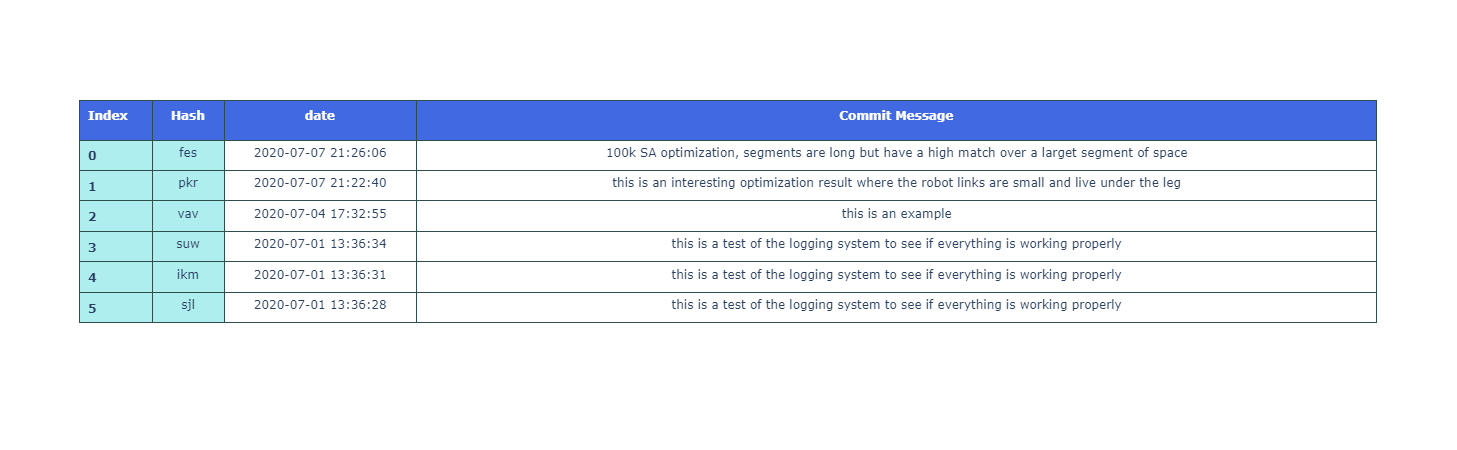

In [291]:
#example of using the logging function
if not asLibrary():
    Exp.Log()

In [214]:
#example using the experiment manager library functions
if not asLibrary():
    #viewing an older experiement
    #exp = Exp()                    #create a new experiment
    #exp.Log()                     #view the saved experiments on file
    #exp.load('yui')                #load a previous via a hash into memmory
    #exp.vis.display()             #view the old solution
    
    #run a new experiment
    exp = Exp()                    #create a new experiment
    exp.scoreMode = "normalize"    #modify the experiment and it's objects to configure an experiment
    exp.run()                     #run an optimization experiment
    #cm = "this is an example"      #commit message
    #exp.save(cm)                   #saving the experiment to hardisk
    #exp.Rm('[0]')                  #remove an experiment by its index or hash

on iteration 0
on iteration 100
on iteration 200
on iteration 300
on iteration 400
on iteration 500
on iteration 600
on iteration 700
on iteration 800
on iteration 900
on iteration 1000


## what are you trying to do with this serialization system in words?? 

* save an optimal solution and nothing else, such that the solution can be viewed in the future, even evaluated in terms of other setups. so the setup itself is NOT to be encoded, just the minimal set of information strictly required to describe the solution. this includes the set of discrete (elbow state) and continuous variables, containted within r, required to reconstruct the robot state. this is the most future proof method, and anything else we might want to know about the solution should be contained in the experiments notebook from where it was constructed. 
* as such, the system can be designed in a way similar to it's previous design, but with a few changes: 
* the object being saved is now a dict, which has the parameterization key, and the value of the xBest, taken from the state of the optimizer. this will pickle easily. 
* the load function should take a experiment instance (self), and index, and load into that instance, the xBest specified by the exp index, and make a modification to the parameterization (since this effects what it means to be xBest) 
* save and load are both instance methods, log is a class method. 


discussion of the goals of the serialized system: 



### Joint Visualization

In [1]:
if not asLibrary():
    exp = Exp()
    exp.load('pkr')
    exp.vis.display("tb")
    #exp.vis.display()

NameError: name 'asLibrary' is not defined

### explore what the penalty function would look like at the boundary

In [7]:
import plotly.graph_objs as go
import numpy as np




## try a penalty function that is a logistic function between 0 and the negative max achievable fxn hard coded. 


#penalty 2 
def penalty2(objFxnVal,xVec):
    """
    penalty function that will returns - value of the objective fxn if outside the 
    bounds, and doesn't effect the value otherwise. 
    """
    pass


#define penalty function
def penalty(x,y):
    """
    calculate the value of the penalty function based on the location of the x,y grid 
    """
    #define the boundaries
    xMax =  4
    xMin =  1
    yMax =  3
    yMin = -1
    
    #calculate the value of the penalty function
    px = penalty_1d(xMax,xMin,x)
    py = penalty_1d(yMax,yMin,y)
    return px + py
    
    
def penalty_dis(xMax,xMin,x):
    """
    a discontinuous penalty function
    """
    if x > xMax or x < xMin:
        return -1e3 
    else: return 0
    
    
def penalty_1d(xMax,xMin,x):
    #define parameters
    n  = .0001 # steepness parameter 
    ρ0 = 2    # radius of influenece. #meters (we should normalize to the size - you deside in the future)
    ρ  = 0    # distance to obstacle (boundary in this case)

    
    #solve for the repulsive field value
    
    #in the middle (this is the normal condition)
    if x < (xMax - ρ0) and x > (xMin + ρ0):
        return 0
    
    #way outside of the boundary, past the influence of penalty function
    elif x >= xMax or x <= xMin:
        return -1e2 #very small number
    
    #approaching the min - side
    elif x > xMin and x <= (xMin + ρ0):
        ρ = x - xMin
        Ur = -1/2*n*(1/ρ - 1/ρ0)**2
        return Ur
    
    #approaching the max side
    elif x < xMax and x >= (xMax - ρ0):
        ρ = xMax - x
        Ur = -1/2*n*(1/ρ - 1/ρ0)**2
        return Ur
    
    else:
        print(xMin,xMax,x)
    

#setup x and y vectors
step = .01
x = np.arange(1-step,4-step,step)  
y = np.arange(-1-step,3-step,step)

#populate Z based on the penalty function

Z = np.zeros((x.shape[0],y.shape[0]))
for i, _ in enumerate(x):
    for j ,_ in enumerate(y):
        Z[i,j] = penalty(x[i] , y[j])


#plot the surface

#init figureWidget
_fig = go.Figure(data=[go.Surface(z=Z, x=x, y=y)])
fig2 = go.FigureWidget(_fig)

fig2.update_layout(title='Penalty function value', title_x=0.5, autosize=False,
                  width=800, height=800)



FigureWidget({
    'data': [{'type': 'surface',
              'uid': 'dc18ff4a-ba09-4f03-8a96-e03cdf67d3d3',
 …

# to do: 

* refactor and ensure that all state information is stored within classes, and can therefore be directly manipulated, instead of being specified using parameters in function calls (use implicit passing rather than explicit) 
* implement sample normalization
* at some point, add a function to serialization which will archive (but not restore) the full state of the object during serialization using a recursive type algorithm. (2hrs)
* (don't connect them for now, there is more work to do on that front) 
* add a ipywidgets progress bar, and a total optimization time thing to SA for style. 
* expanding baysian optimization to be more general
* develop 2 different importance functions to apply over the space 
* implement reference constraints from the robot class to the visualizer
* start debugging an actual optimization with SA, over in numerical experiments
* if you complete a successful optimization, put the rest of the time into



Design Discussion: 

* so far in our system we have 5 main objects, connected in a hierarchical arrangement, through composition
* exp manager contains:
    * robot
    * human
    * optimizer
    * visualizer
* each object contains state which is (relatively) self contained, and which can be directly modified through access from the top level experiment manager, which is great. it means in essence, there is a default experiment that can be run, but that with very small tweeks, you can run a totally different experiment, for instance, with a different sampling method, or a different optimization technique, or optimization parameters. 
* the conceptual problem I'm running into is what to do about "shared state"
* an example of this is that the optimizer needs to know about the bounds on the state variable x
* another example is that the visualizer needs to know about these limits as well, and should responsively update these.
* so the question is, how should we handle this state sharing? should it all be functional in nature? for instance, should we construct the optimizers with a function handle that allows the optimizer to query what the limit is, and it is then returned by the robot object?
* an alternative approach - which is how the system is implemented right now is duplicated state. so all objects are initialized, then the objects are "set-up" which means individually configured as they should be, and then a second initialization takes place which assigns the duplicated state to the proper locations within the objects, and then objects are then properly decoupled. it's not clear to me which approach is better at this time. 
* for now, I'll go with the state replication / 2nd initialization approach, but I'll give it some thought in the future for a possible refactor. 
* refactor so that things which are currently functional in the 

Notes from meeting:
* think about a way of measureing the sensitivity of the solution to changes in human limb length
* possibly think about stochastic optimization, where the human would have limb lengths drawn from a population, but honestly, let's not implement that anytime soon. 
* the idea of starting Nelder-mead from a variety of locations within the state space, and seeing how / if the solutions converge to a single point, different wells, or what have you. 
* if it's convex, they will all go to a global 
* including the motor torque directly in the optimization
* re-thinking the nature of the scoring function slightly, for different circumstances.
* including one or two spacial importance functions in the human class (only visualized in the human visualizer, no need for it in the joint visualizer please) 
* including the ability for the optimizer to manipulate the torque directly via an alternative parameterization
* refactor as per design discussion
* refactor to replace specific function arguments in the visualizer for example, with object state, so that it can be manipulated from the outside via parameter manipulation 

<a id="notes"></a>
## notes:

speed up code with cython
https://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/?fbclid=IwAR1_KPRJACFUJk6-TYb1DqumE9Cn3hk40QUOl10UCyItL2z4Ft5x_s-Nc60
numba, JIT

python optimization with pyomo http://egon.cheme.cmu.edu/ewo/docs/EWO_Seminar_03_10_2017.pdf
